# <a name="C1"><font color='Blue'><h1><center>I. Import package nécessaire</center></h1></font></a>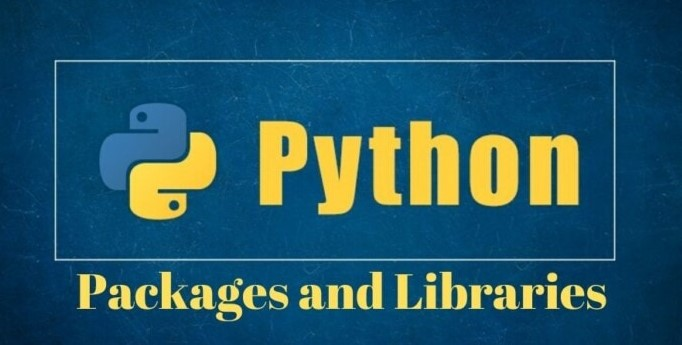

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
import joblib
from function_utils import *

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

In [4]:
convertMillis(4564826.023)

'52D : 20h : 0min : 26s'

</Br>

</Br>

# <a name="C2"><font color='orange'><h1><center>II. Import Dataset</center></h1></font></a>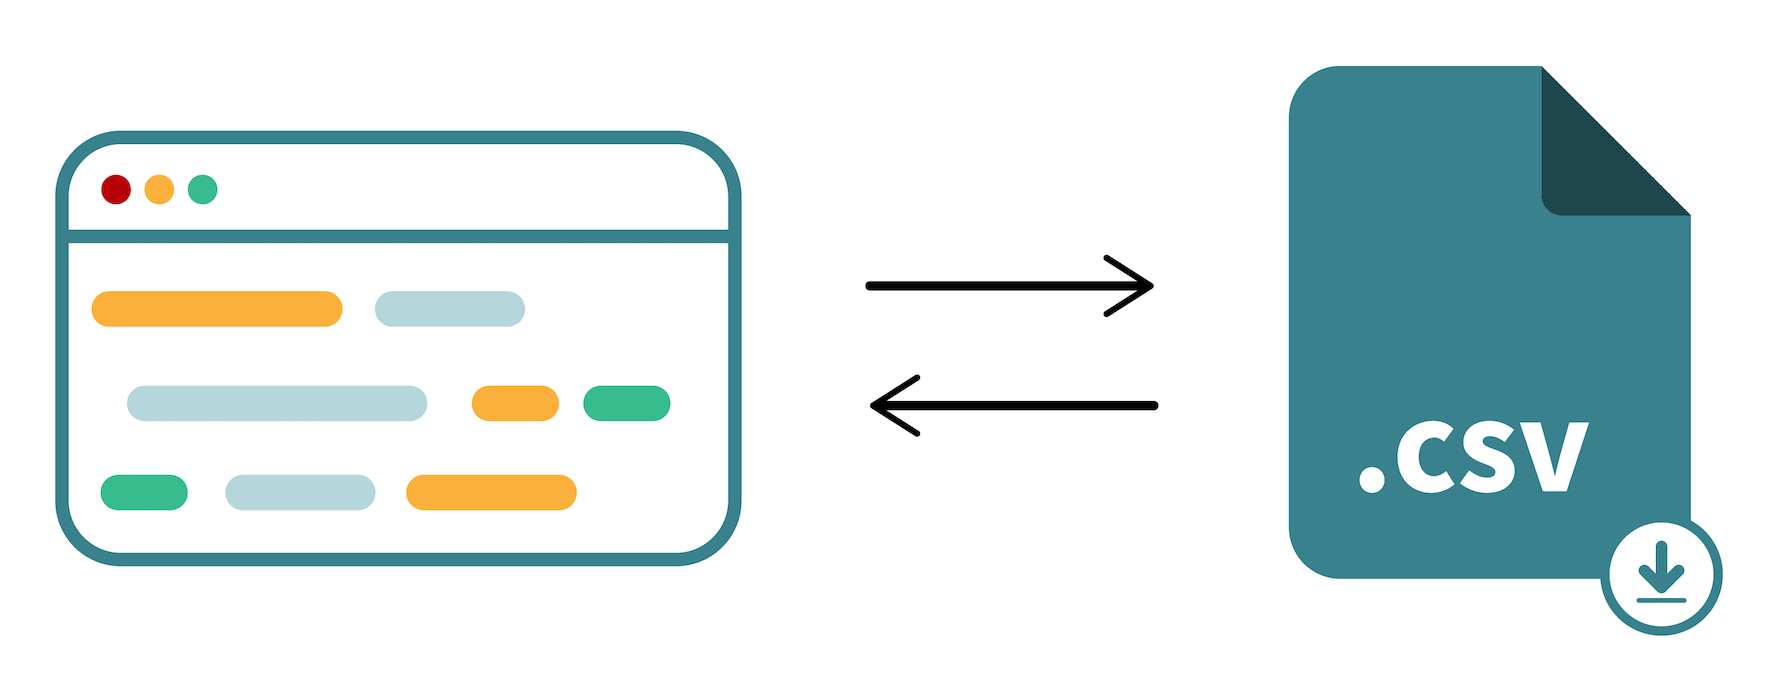

In [5]:
df = pd.read_csv('data/source/application_train.csv')
test_df = pd.read_csv('data/source/application_test.csv')

In [6]:
def clean_data1(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    data = data[data['CODE_GENDER'] != 'XNA']

    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        data[bin_feature], uniques = pd.factorize(data[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    data['PERC_CREDIT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['INCOME_PER_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN']+1)# revenu par enfant
    data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['DEF_RATE'] = data['DEF_60_CNT_SOCIAL_CIRCLE']/data['DEF_30_CNT_SOCIAL_CIRCLE'] 
    data['CHIDREN_RATE'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']# ratio d'enfant

    # ratio defaillance
    data['DEF_30_RATE'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] / data['OBS_30_CNT_SOCIAL_CIRCLE']
    data['DEF_60_RATE'] = data['DEF_60_CNT_SOCIAL_CIRCLE'] / data['OBS_60_CNT_SOCIAL_CIRCLE']
    
    return data

In [7]:
df = clean_data1(df)
test_df = clean_data1(test_df)

## <font color='orange'> * Import sauvegarde dataset</font>

In [8]:
if 'df' not in locals():
    print("Le dataset sera importé à partir d'une sauvegarde .csv")
    df = pd.read_csv('data/cleaned/df_cleaned.csv',sep=';')

In [9]:
df.shape

(307507, 131)

In [10]:
import joblib
important_features = joblib.load('data/cleaned/list_col_to_keep_from_train_application_final.joblib')

In [11]:
df = df[ important_features]
test_df = test_df[[f for f in important_features if f != 'TARGET']]

In [12]:
df.head()

,NAME_INCOME_TYPE,AMT_REQ_CREDIT_BUREAU_MON,NAME_EDUCATION_TYPE,FONDKAPREMONT_MODE,OCCUPATION_TYPE,FLAG_OWN_CAR,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REGION_POPULATION_RELATIVE,AMT_REQ_CREDIT_BUREAU_WEEK,...,DAYS_EMPLOYED,SK_ID_CURR,REG_CITY_NOT_LIVE_CITY,AMT_GOODS_PRICE,TARGET,FLAG_DOCUMENT_3,FLAG_DOCUMENT_11,OBS_30_CNT_SOCIAL_CIRCLE,FLAG_PHONE,FLAG_DOCUMENT_6
0,Working,0.0,Secondary / secondary special,reg oper account,Laborers,0,0,0,0.018801,0.0,...,-637.0,100002,0,351000.0,1,1,0,2.0,1,0
1,State servant,0.0,Higher education,reg oper account,Core staff,0,0,0,0.003541,0.0,...,-1188.0,100003,0,1129500.0,0,1,0,1.0,1,0
2,Working,0.0,Secondary / secondary special,NaN,Laborers,1,0,0,0.010032,0.0,...,-225.0,100004,0,135000.0,0,0,0,0.0,1,0
3,Working,NaN,Secondary / secondary special,NaN,Laborers,0,0,0,0.008019,NaN,...,-3039.0,100006,0,297000.0,0,1,0,2.0,0,0
4,Working,0.0,Secondary / secondary special,NaN,Core staff,0,1,0,0.028663,0.0,...,-3038.0,100007,0,513000.0,0,0,0,0.0,0,0


</Br>

</Br>

# <a name="C3"><font color='green'><h1><center>III. Machine Learnig</center></h1></font></a>

## <a name="C31"><font color='green'>III.1 packages nécessaires modélisation</font></a>
</Br>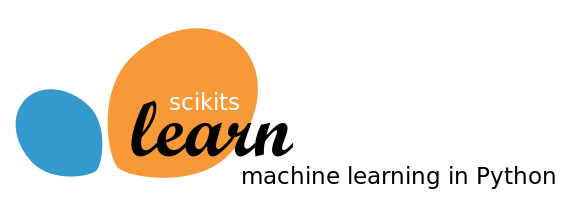

In [13]:
# Modelisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (HistGradientBoostingClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier, 
                              AdaBoostClassifier)

from lightgbm import LGBMClassifier as lgbmc
from sklearn import dummy

# Cross-Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

# Metrics
from sklearn.metrics import (roc_auc_score, f1_score, recall_score, balanced_accuracy_score, 
                             accuracy_score, log_loss ,precision_score,
                            roc_curve, confusion_matrix, ConfusionMatrixDisplay )

# pipeline data transformation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler

</Br>

</Br>

## <a name="C32"><font color='green'>III.2 Train test Validation split</font></a>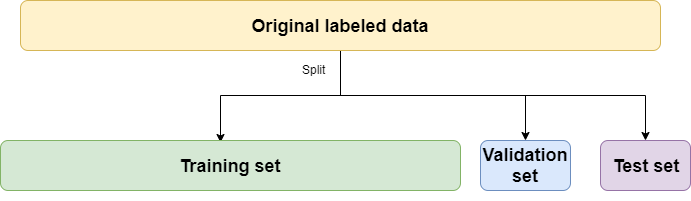

In [14]:
X = df.drop(columns=['TARGET','SK_ID_CURR'])
y = df['TARGET']

## inf
X[X==np.inf] = np.nan

random_seed = 971

# Le dataset est grand on peut diviser le données en train test valiation 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=random_seed,stratify=y) #~~100000 samples
X_test, X_validation, y_test, y_validation = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed,stratify=y_test) 

print('Le dataset Train se compose de: {0} lignes et {1} colonnes'.format( X_train.shape[0],X_train.shape[1]) )
print('Le dataset Test se compose de: {0} lignes et {1} colonnes'.format( X_test.shape[0],X_test.shape[1]) )
print('Le dataset Validation se compose de: {0} lignes et {1} colonnes'.format(X_validation.shape[0], X_validation.shape[1]) )

Le dataset Train se compose de: 215254 lignes et 39 colonnes
Le dataset Test se compose de: 46126 lignes et 39 colonnes
Le dataset Validation se compose de: 46127 lignes et 39 colonnes


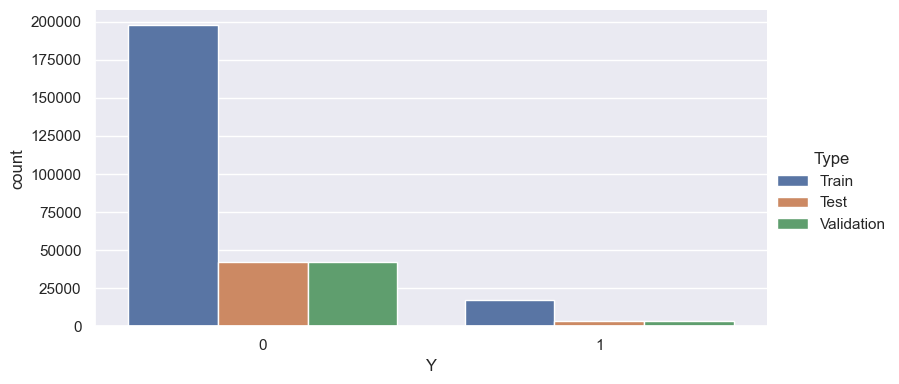

In [15]:
graphData = pd.concat([
    pd.DataFrame(np.c_[y_train,['Train' for x in y_train]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_test,['Test' for x in y_test]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_validation,['Validation' for x in y_validation]],columns=['Y','Type'] )],
    axis=0)

graphData.Y=graphData.Y.astype(np.int16)

sns.catplot(data=graphData, kind='count', x='Y', height=4, aspect=2,hue='Type');

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_INCOME_TYPE             215254 non-null  object 
 1   AMT_REQ_CREDIT_BUREAU_MON    186248 non-null  float64
 2   NAME_EDUCATION_TYPE          215254 non-null  object 
 3   FONDKAPREMONT_MODE           68080 non-null   object 
 4   OCCUPATION_TYPE              147891 non-null  object 
 5   FLAG_OWN_CAR                 215254 non-null  int64  
 6   REG_CITY_NOT_WORK_CITY       215254 non-null  int64  
 7   REG_REGION_NOT_LIVE_REGION   215254 non-null  int64  
 8   REGION_POPULATION_RELATIVE   215254 non-null  float64
 9   AMT_REQ_CREDIT_BUREAU_WEEK   186248 non-null  float64
 10  REG_REGION_NOT_WORK_REGION   215254 non-null  int64  
 11  AMT_ANNUITY                  215243 non-null  float64
 12  DAYS_REGISTRATION            215254 non-null  float64
 13

In [17]:
X_train.isna().sum()/X_train.shape[0]

NAME_INCOME_TYPE               0.000000
AMT_REQ_CREDIT_BUREAU_MON      0.134752
NAME_EDUCATION_TYPE            0.000000
FONDKAPREMONT_MODE             0.683722
OCCUPATION_TYPE                0.312947
FLAG_OWN_CAR                   0.000000
REG_CITY_NOT_WORK_CITY         0.000000
REG_REGION_NOT_LIVE_REGION     0.000000
REGION_POPULATION_RELATIVE     0.000000
AMT_REQ_CREDIT_BUREAU_WEEK     0.134752
REG_REGION_NOT_WORK_REGION     0.000000
AMT_ANNUITY                    0.000051
DAYS_REGISTRATION              0.000000
REGION_RATING_CLIENT_W_CITY    0.000000
FLAG_DOCUMENT_5                0.000000
NAME_TYPE_SUITE                0.004242
AMT_INCOME_TOTAL               0.000000
FLAG_OWN_REALTY                0.000000
FLAG_DOCUMENT_13               0.000000
AMT_REQ_CREDIT_BUREAU_YEAR     0.134752
DAYS_ID_PUBLISH                0.000000
AMT_REQ_CREDIT_BUREAU_HOUR     0.134752
FLAG_WORK_PHONE                0.000000
DAYS_BIRTH                     0.000000
DEF_30_CNT_SOCIAL_CIRCLE       0.003284


</Br>

</Br>

</Br>

## <a name="C33"><font color='green'>III.3 Création pipeline preprocessing data</font></a>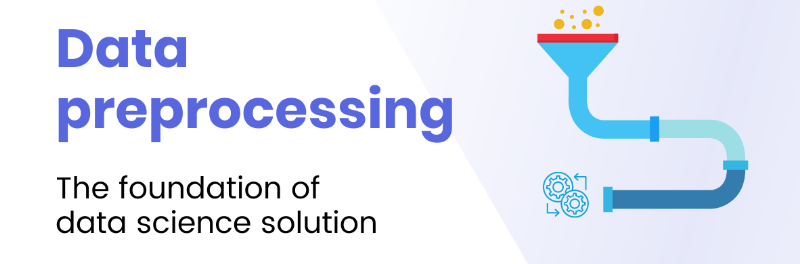

In [18]:

def intermediaire_pipe_pretraitement(X_train,model):
    """
    Fonction qui crée un pipeline, en prétraitant les données en amont puis
    en appliquant un model à la fin

    Args:
        X_train (pandas.core.frame.DataFrame): Training Dataset.
        model (type): model de type sklearn. C'est à dire possedant la méthode fit

    Returns:
        type: Description de la valeur de retour.

    Raises:
        ErrorType: Description de l'erreur éventuellement levée.

    Examples:
        Exemples d'utilisation de la fonction.
    """    
    #Numerical featues
    numeric_features = make_column_selector(dtype_include=np.float64)
    numeric_transformer = Pipeline(
        steps=[('impNumerical', SimpleImputer(strategy="median")) ]
    )

    #Discretes features
    discret_features = make_column_selector(dtype_include=np.int64)
    discret_transformer = Pipeline(
        steps=[('impDiscret', SimpleImputer(strategy = 'most_frequent')) ]
    )

    # categorials features
    categorical_features = make_column_selector(dtype_include="object")
    categorical_transformer = Pipeline(
        steps=[
            ('impCat', SimpleImputer(strategy = 'most_frequent')),
            ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore',sparse=False)),
        ])

    # columntransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num",  numeric_transformer, numeric_features),
            ("disc", discret_transformer, discret_features),
            ("cat",  categorical_transformer, categorical_features),
        ])

    # pipeline
    intermediaire_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model",model)]
    )
    
    return intermediaire_pipeline

In [19]:
# Entraîner le pipeline sur les données d'entraînement
intermediaire_pipeline = intermediaire_pipe_pretraitement( X_train,StandardScaler() )
#intermediaire_pipeline = overSamplingFunction( X_train,StandardScaler() )
    
# Application pipeline    
X_train_pt = pd.DataFrame(intermediaire_pipeline.fit_transform(X_train),
                          columns=intermediaire_pipeline.get_feature_names_out()
                         )

In [20]:
intermediaire_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000265569E4220>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000265569E4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000265569E4670>)])),
                ('model', StandardScaler())])

In [21]:
X_train_pt.head()

,num__AMT_REQ_CREDIT_BUREAU_MON,num__REGION_POPULATION_RELATIVE,num__AMT_REQ_CREDIT_BUREAU_WEEK,num__AMT_ANNUITY,num__DAYS_REGISTRATION,num__AMT_INCOME_TOTAL,num__AMT_REQ_CREDIT_BUREAU_YEAR,num__AMT_REQ_CREDIT_BUREAU_HOUR,num__DEF_30_CNT_SOCIAL_CIRCLE,num__EXT_SOURCE_3,...,cat__OCCUPATION_TYPE_Sales staff,cat__OCCUPATION_TYPE_Secretaries,cat__OCCUPATION_TYPE_Security staff,cat__OCCUPATION_TYPE_Waiters/barmen staff,cat__NAME_TYPE_SUITE_Family,cat__NAME_TYPE_SUITE_Group of people,cat__NAME_TYPE_SUITE_Other_A,cat__NAME_TYPE_SUITE_Other_B,"cat__NAME_TYPE_SUITE_Spouse, partner",cat__NAME_TYPE_SUITE_Unaccompanied
0,-0.268501,0.309525,-0.155709,-0.119380,1.022546,1.111520,0.693336,-0.070538,-0.319182,-0.991257,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
1,-0.268501,0.309525,-0.155709,-0.288185,1.294713,-0.100237,-0.440641,-0.070538,-0.319182,-2.269847,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
2,-0.268501,1.830912,-0.155709,-0.306182,-0.570118,0.505641,-0.440641,-0.070538,1.930939,0.111851,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
3,0.890082,-0.012079,-0.155709,0.301389,0.557758,1.515439,1.260324,-0.070538,6.431182,-1.092198,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
4,-0.268501,-0.716342,-0.155709,0.639929,-0.014987,0.182506,0.693336,-0.070538,-0.319182,-0.021980,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,5.114485,-2.081448


In [22]:
X_train_pt.filter(regex='^cat', axis=1).head()

,cat__NAME_INCOME_TYPE_Commercial associate,cat__NAME_INCOME_TYPE_Maternity leave,cat__NAME_INCOME_TYPE_Pensioner,cat__NAME_INCOME_TYPE_State servant,cat__NAME_INCOME_TYPE_Student,cat__NAME_INCOME_TYPE_Unemployed,cat__NAME_INCOME_TYPE_Working,cat__NAME_EDUCATION_TYPE_Higher education,cat__NAME_EDUCATION_TYPE_Incomplete higher,cat__NAME_EDUCATION_TYPE_Lower secondary,...,cat__OCCUPATION_TYPE_Sales staff,cat__OCCUPATION_TYPE_Secretaries,cat__OCCUPATION_TYPE_Security staff,cat__OCCUPATION_TYPE_Waiters/barmen staff,cat__NAME_TYPE_SUITE_Family,cat__NAME_TYPE_SUITE_Group of people,cat__NAME_TYPE_SUITE_Other_A,cat__NAME_TYPE_SUITE_Other_B,"cat__NAME_TYPE_SUITE_Spouse, partner",cat__NAME_TYPE_SUITE_Unaccompanied
0,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,-0.009145,0.966733,-0.567526,-0.186162,-0.112091,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
1,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,-0.009145,0.966733,-0.567526,-0.186162,-0.112091,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
2,1.814349,-0.003733,-0.467432,-0.275566,-0.008348,-0.009145,-1.034412,-0.567526,-0.186162,-0.112091,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
3,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,-0.009145,0.966733,1.762035,-0.186162,-0.112091,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435
4,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,-0.009145,0.966733,-0.567526,-0.186162,-0.112091,...,-0.341351,-0.065766,-0.149438,-0.06548,-0.387587,-0.030035,-0.053572,-0.076118,5.114485,-2.081448


In [23]:
del X_train_pt
gc.collect()

3950

## <a name="C33"><font color='green'>III.3 Comparaison performance des différents Models</font></a>

In [24]:
score_auc = dict()

In [25]:
idx_risk = np.where(y_test == 1.0)[0]
idx_bon = np.random.choice( np.where(y_test != 1.0)[0], size = len( idx_risk ), replace = False)


X_test_equil = pd.concat([X_test.iloc[idx_risk,:],
                          X_test.iloc[idx_bon,:] ],axis=0)

y_test_equil = pd.concat([y_test.iloc[idx_risk],
                          y_test.iloc[idx_bon] ])

### <a name="C331"><font color='green'>III.3.1 Dummy Estimateur</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 50.00%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.00%
L'entrainement s'exécute en moyenne en : 1s


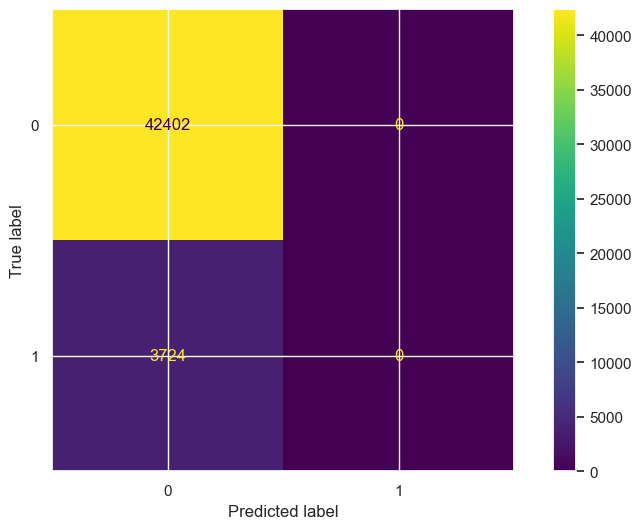

CPU times: total: 1.61 s
Wall time: 4.72 s


In [26]:
%%time
# Use the copy module of Python for deep copy operations
dummy_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
dummy_pipe.steps.append(['clf',dummy.DummyClassifier(strategy='most_frequent')])
score_auc['dummyEstimator'] = cross_validate(dummy_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['dummyEstimator']['fit_time'].mean(),4)))


cm = confusion_matrix(y_test, dummy_pipe.fit(X_train, y_train).predict(X_test), labels=dummy_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_pipe.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Count'>

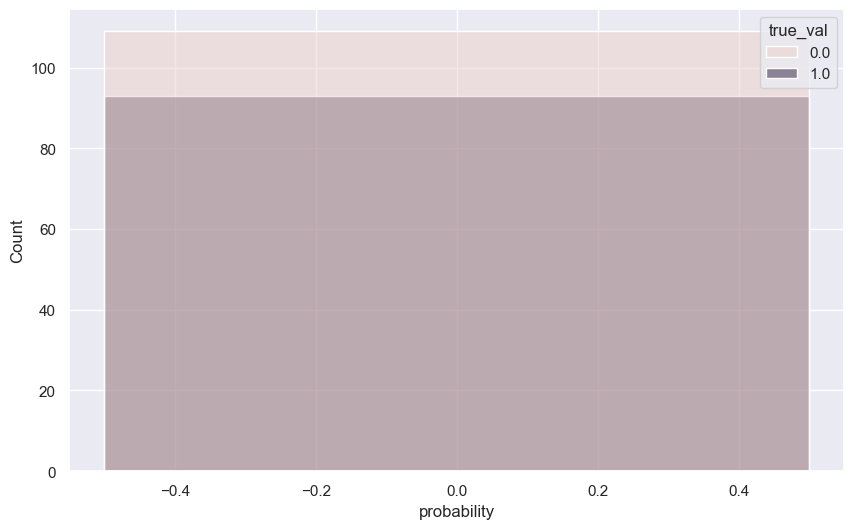

In [27]:
p_clf = pd.DataFrame(dummy_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val')

### <a name="C332"><font color='green'>III.3.2 Logistic Regression</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.63%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.39%
L'entrainement s'exécute en moyenne en : 3s


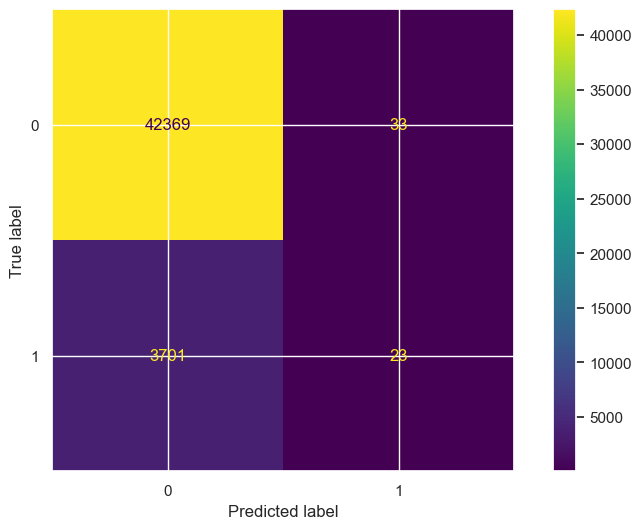

CPU times: total: 3.42 s
Wall time: 8.81 s


In [28]:
%%time
# Use the copy module of Python for deep copy operations
regLog_pipe_raw = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
regLog_pipe_raw.steps.append(['clf',LogisticRegression()])

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_Raw'] = cross_validate(regLog_pipe_raw, X_train, y_train, 
                                         cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Raw']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, regLog_pipe_raw.fit(X_train, y_train).predict(X_test), labels=regLog_pipe_raw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regLog_pipe_raw.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Percent'>

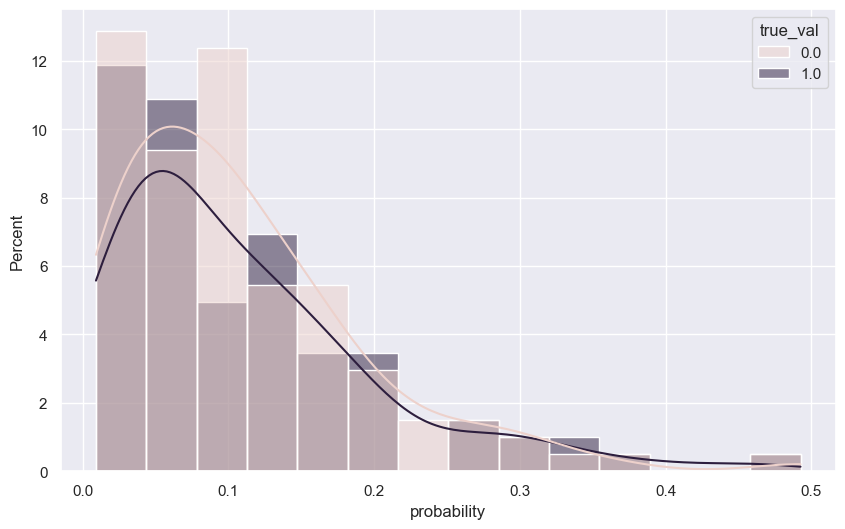

In [29]:
p_clf = pd.DataFrame(regLog_pipe_raw.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent')

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.64%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 67.47%
L'entrainement s'exécute en moyenne en : 3s


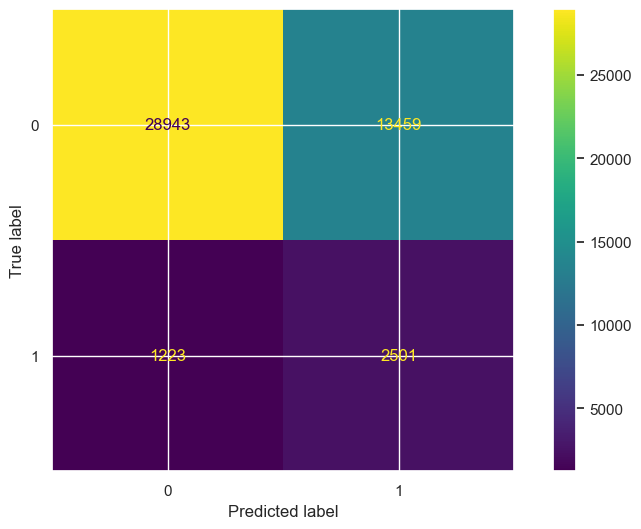

CPU times: total: 3.12 s
Wall time: 7.71 s


In [30]:
%%time
# Use the copy module of Python for deep copy operations
regLog_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
regLog_pipe.steps.append(['clf',LogisticRegression(class_weight='balanced')])

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_classweight'] = cross_validate(regLog_pipe, X_train, y_train, cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_classweight']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_classweight']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_classweight']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, regLog_pipe.fit(X_train, y_train).predict(X_test), labels=regLog_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regLog_pipe.classes_)
disp.plot()
plt.show()

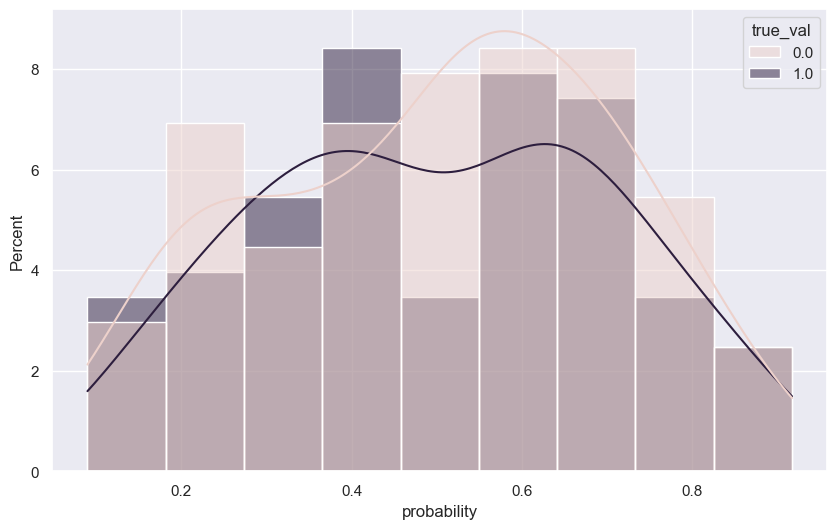

In [31]:
p_clf = pd.DataFrame(regLog_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C333"><font color='green'>III.3.3 Adaboost</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.67%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.90%
L'entrainement s'exécute en moyenne en : 27s


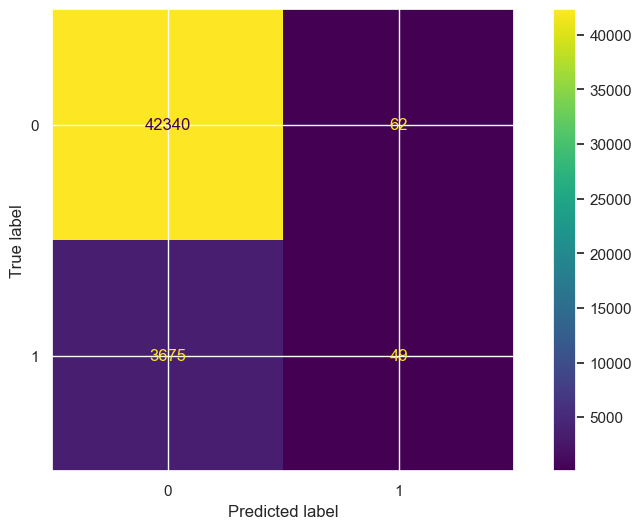

CPU times: total: 25.3 s
Wall time: 55.1 s


In [32]:
%%time
# Use the copy module of Python for deep copy operations
Ada_pipe = deepcopy(intermediaire_pipeline)
Ada_pipe.steps.append(['clf',AdaBoostClassifier()])

#Compute AUC score
score_auc['Adaboost'] = cross_validate(Ada_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Adaboost']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, Ada_pipe.fit(X_train, y_train).predict(X_test), labels=Ada_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = Ada_pipe.classes_)
disp.plot()
plt.show()

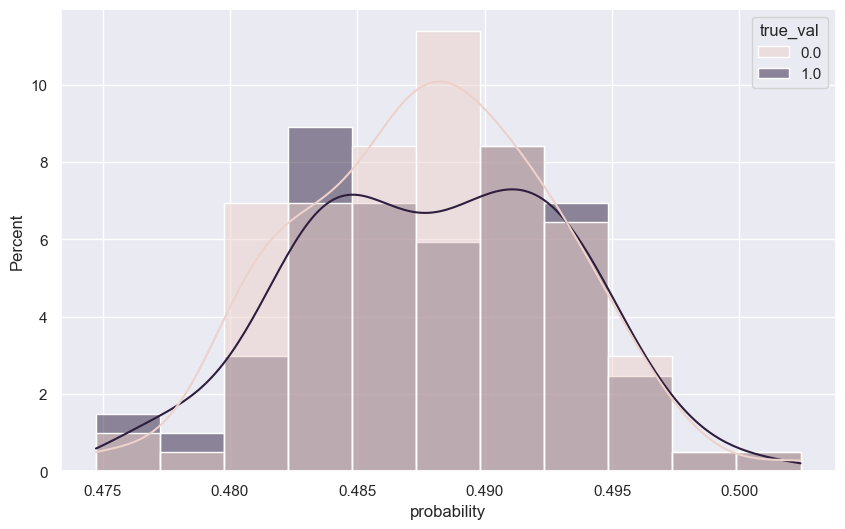

In [33]:
p_clf = pd.DataFrame(Ada_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C334"><font color='green'>III.3.4 Random Forest</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 70.95%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.10%
L'entrainement s'exécute en moyenne en : 28s


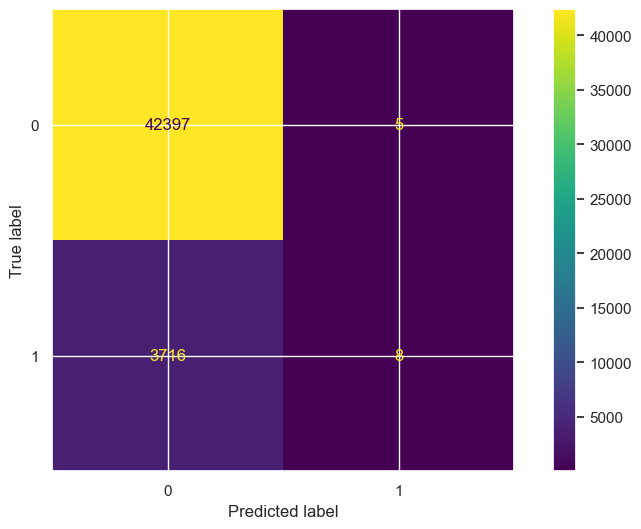

CPU times: total: 1min 31s
Wall time: 41.1 s


In [34]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['clf',RandomForestClassifier(n_jobs=-1)])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, RF_pipe.fit(X_train, y_train).predict(X_test), labels= RF_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= RF_pipe.classes_)
disp.plot()
plt.show()

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 71.84%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.04%
L'entrainement s'exécute en moyenne en : 26s


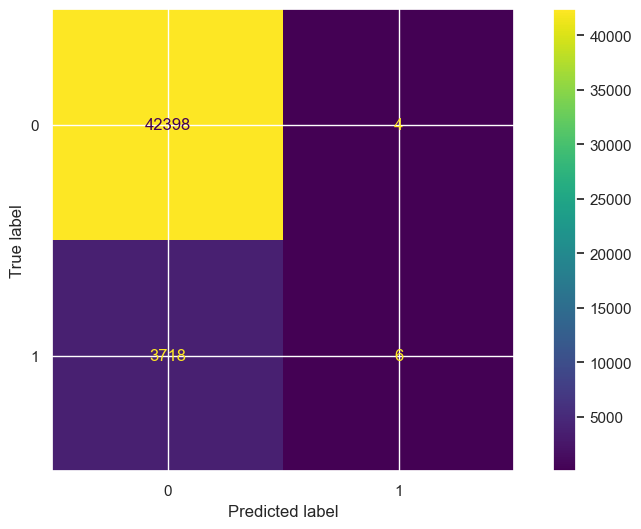

CPU times: total: 1min 25s
Wall time: 38.7 s


In [35]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['clf',RandomForestClassifier(n_jobs=-1,class_weight="balanced")])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, RF_pipe.fit(X_train, y_train).predict(X_test), labels= RF_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= RF_pipe.classes_)
disp.plot()
plt.show()

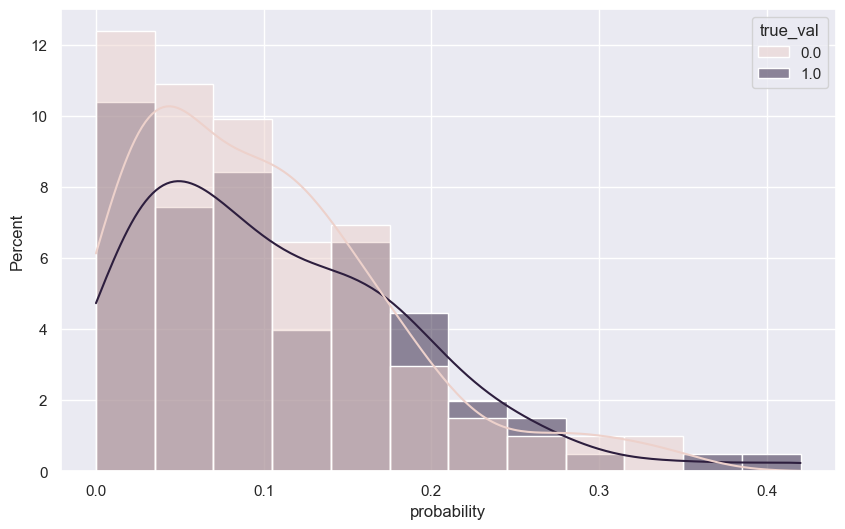

In [36]:
p_clf = pd.DataFrame(RF_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 71.65%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.05%
L'entrainement s'exécute en moyenne en : 28s


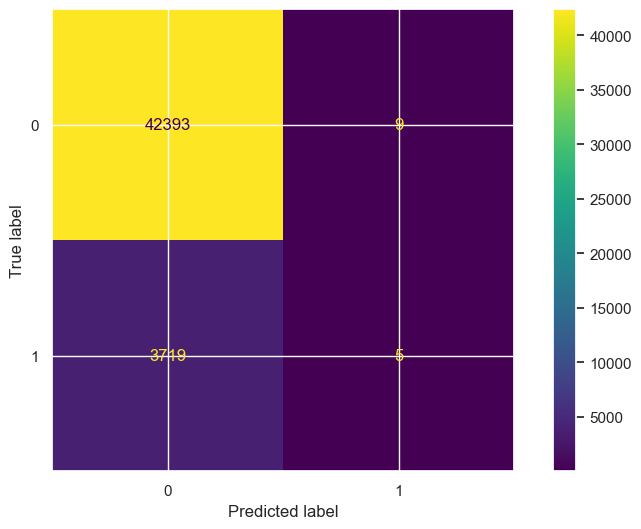

CPU times: total: 1min 29s
Wall time: 42.6 s


In [37]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['clf',RandomForestClassifier(n_jobs=-1,class_weight="balanced_subsample")])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, RF_pipe.fit(X_train, y_train).predict(X_test), labels= RF_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= RF_pipe.classes_)
disp.plot()
plt.show()

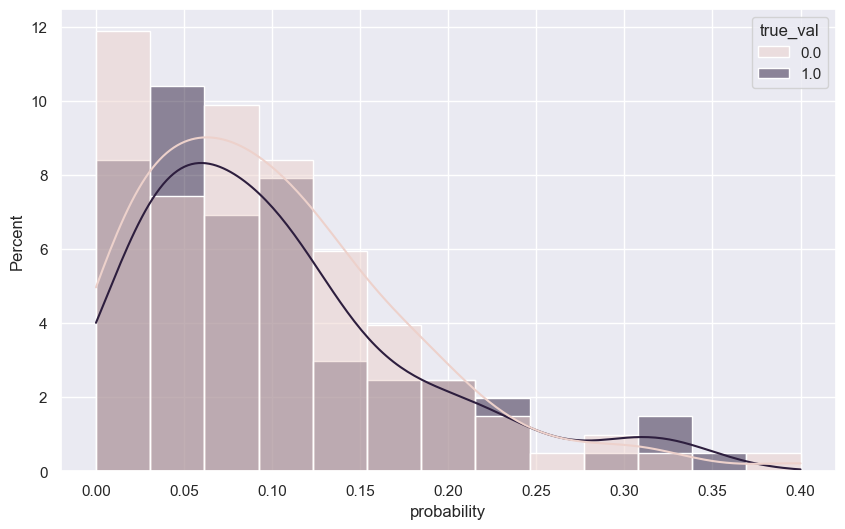

In [38]:
p_clf = pd.DataFrame(RF_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C335"><font color='green'>III.3.5  HistGradientBoostingClassifier</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.39%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 68.15%
L'entrainement s'exécute en moyenne en : 10s


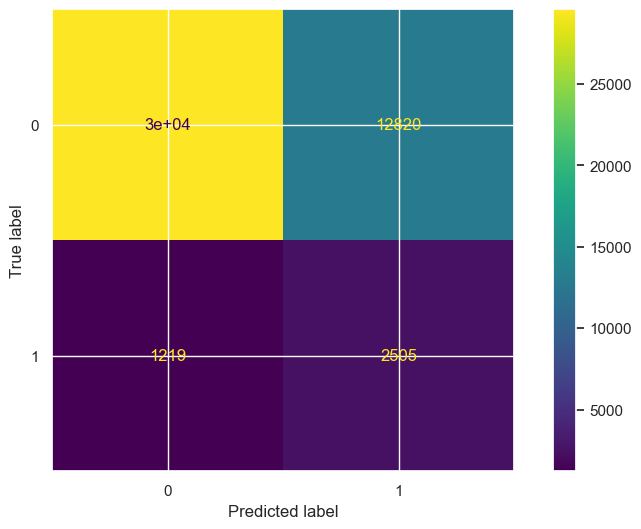

CPU times: total: 31.9 s
Wall time: 17.5 s


In [39]:
%%time
# Use the copy module of Python for deep copy operations
HistGB_pipe = deepcopy(intermediaire_pipeline)
HistGB_pipe.steps.append(['clf',HistGradientBoostingClassifier(class_weight = 'balanced')])

#Compute AUC score
score_auc['HistGradientBoosting'] = cross_validate(HistGB_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGradientBoosting']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, HistGB_pipe.fit(X_train, y_train).predict(X_test), labels=HistGB_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=HistGB_pipe.classes_)
disp.plot()
plt.show()

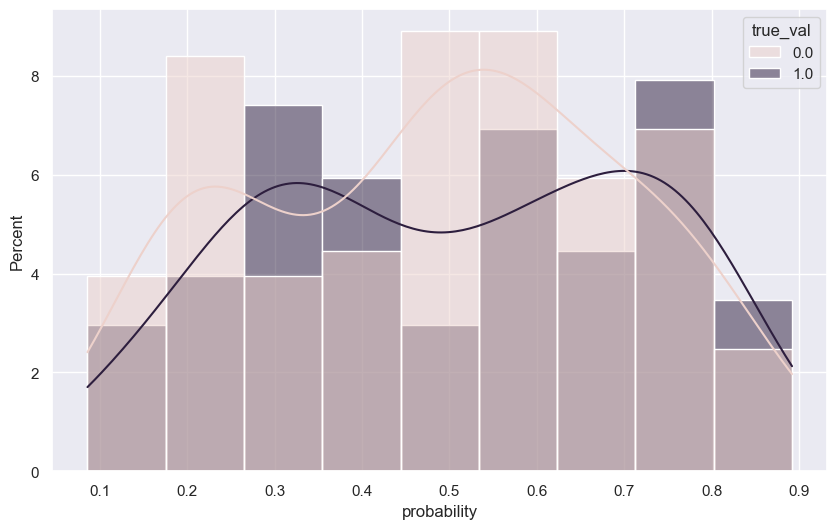

In [40]:
p_clf = pd.DataFrame(HistGB_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C336"><font color='green'>III.3.6 lightGBM</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.44%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 68.06%
L'entrainement s'exécute en moyenne en : 2s


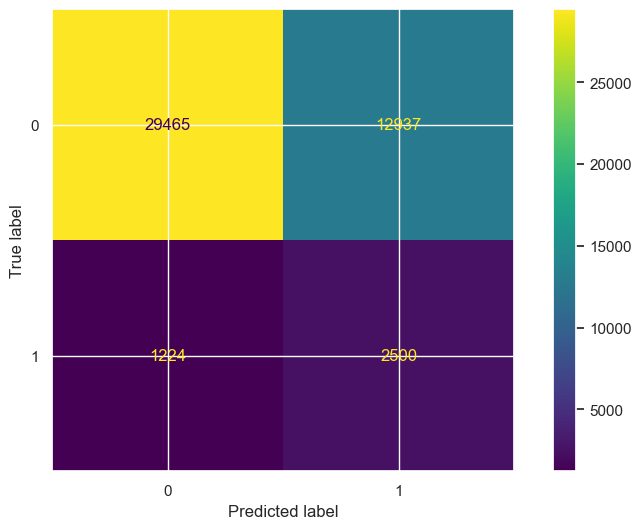

CPU times: total: 13.6 s
Wall time: 9.93 s


In [41]:
%%time

#lgbmc = LGBMClassifier(nthread=4,)

# Use the copy module of Python for deep copy operations
LGBM_pipe = deepcopy(intermediaire_pipeline)
LGBM_pipe.steps.append(['clf',lgbmc(scale_pos_weight = 11.3869)])

#Compute AUC score
score_auc['LightGBM'] = cross_validate(LGBM_pipe,X_train, y_train,cv = 5, n_jobs = 3, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['LightGBM']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, LGBM_pipe.fit(X_train, y_train).predict(X_test), labels=LGBM_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LGBM_pipe.classes_)
disp.plot()
plt.show()

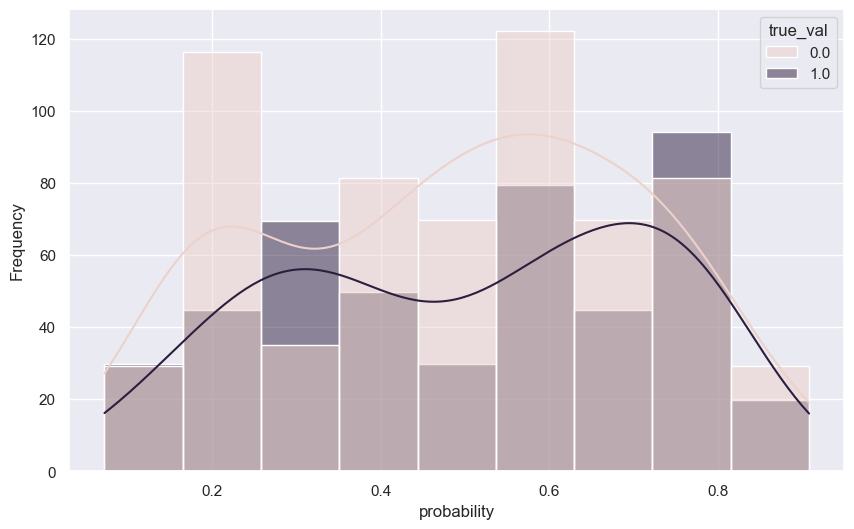

In [42]:
p_clf = pd.DataFrame(LGBM_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'frequency');

### <a name="C337"><font color='green'>III.3.7 Gradient Boosting</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.26%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.53%
L'entrainement s'exécute en moyenne en : 50s


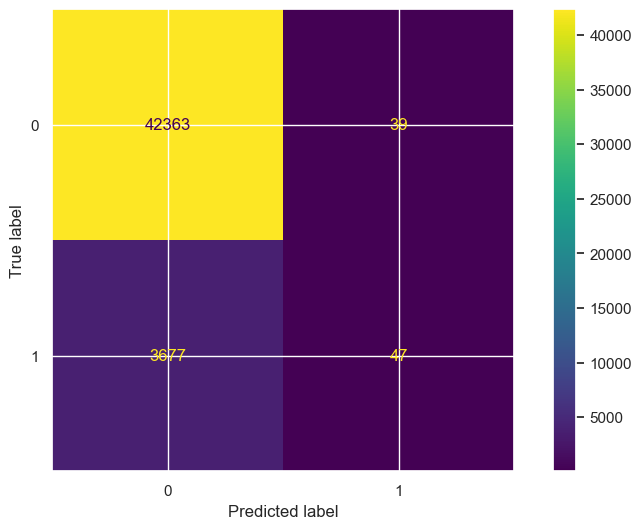

CPU times: total: 1min 39s
Wall time: 3min 33s


In [43]:
%%time
# Use the copy module of Python for deep copy operations
GradientBoosting_pipe = deepcopy(intermediaire_pipeline)
GradientBoosting_pipe.steps.append(['clf',GradientBoostingClassifier()])

#Compute AUC score
score_auc['GradientBoosting'] = cross_validate(GradientBoosting_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['GradientBoosting']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['GradientBoosting']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['GradientBoosting']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, GradientBoosting_pipe.fit(X_train, y_train).predict(X_test), labels=GradientBoosting_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GradientBoosting_pipe.classes_)
disp.plot()
plt.show()

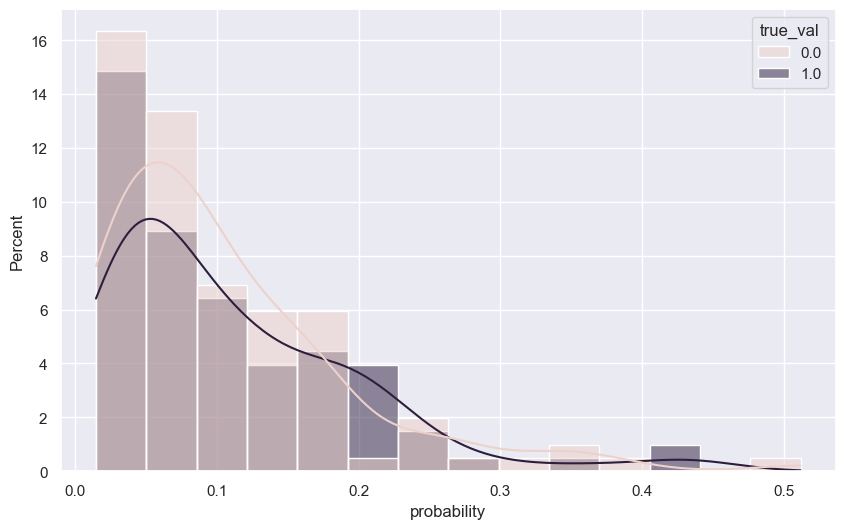

In [44]:
p_clf = pd.DataFrame(GradientBoosting_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C338"><font color='green'>III.3.8 Linear Discriminant Analysis</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.57%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.84%
L'entrainement s'exécute en moyenne en : 4s


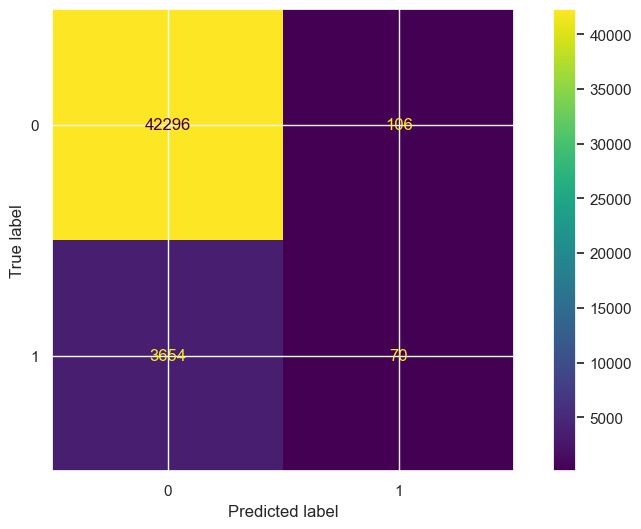

CPU times: total: 5.67 s
Wall time: 9.4 s


In [45]:
%%time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Use the copy module of Python for deep copy operations
LDA_pipe = deepcopy(intermediaire_pipeline)
LDA_pipe.steps.append(['clf',LinearDiscriminantAnalysis()])

#Compute AUC score
score_auc['Discriminant Analysis'] = cross_validate(LDA_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Discriminant Analysis']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Discriminant Analysis']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Discriminant Analysis']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, LDA_pipe.fit(X_train, y_train).predict(X_test), labels=LDA_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LDA_pipe.classes_)
disp.plot()
plt.show()

### <a name="C339"><font color='green'>III.3.9 Perceptron</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 59.68%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 57.28%
L'entrainement s'exécute en moyenne en : 2s


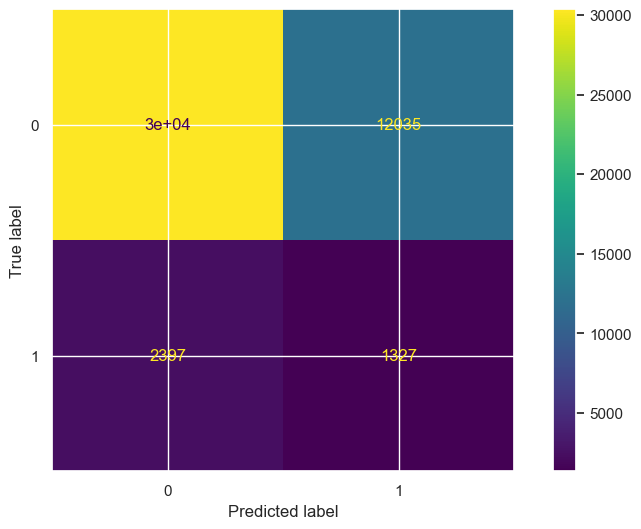

CPU times: total: 2.61 s
Wall time: 6.62 s


In [46]:
%%time

from sklearn.linear_model import Perceptron
# Use the copy module of Python for deep copy operations
Perceptron_pipe = deepcopy(intermediaire_pipeline)
Perceptron_pipe.steps.append(['clf',Perceptron(eta0=0.001,penalty='elasticnet',
                                                      max_iter = 100000,
                                                      early_stopping = True,
                                                      validation_fraction = 0.3,
                                                      n_jobs=-1,n_iter_no_change=10,
                                                      class_weight = 'balanced'
                                                     )])

#Compute AUC score
score_auc['Perceptron'] = cross_validate(Perceptron_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Perceptron']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Perceptron']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Perceptron']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, Perceptron_pipe.fit(X_train, y_train).predict(X_test), labels=Perceptron_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Perceptron_pipe.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Percent'>

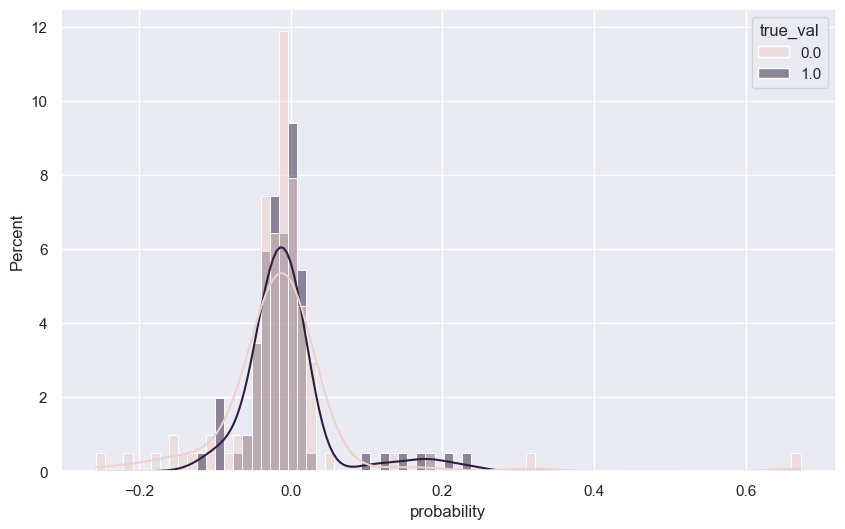

In [47]:
p_clf = pd.DataFrame(Perceptron_pipe.decision_function(X_test_equil),columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde = True, stat= 'percent')

### <a name="C3310"><font color='green'>III.3.10 Passive Aggressive Classifier</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 59.27%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 52.84%
L'entrainement s'exécute en moyenne en : 2s


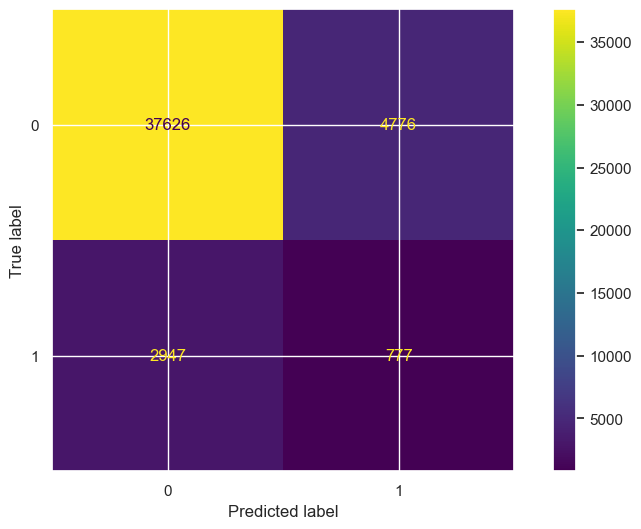

CPU times: total: 2.47 s
Wall time: 5.48 s


In [48]:
%%time

from sklearn.linear_model import PassiveAggressiveClassifier
# Use the copy module of Python for deep copy operations
PAC_pipe = deepcopy(intermediaire_pipeline)
PAC_pipe.steps.append(['clf',PassiveAggressiveClassifier(
    max_iter = 100000,
    early_stopping = True,
    validation_fraction = 0.3,
    n_jobs=-1,n_iter_no_change=10, 
    tol=1e-3)])

#Compute AUC score
score_auc['Passive Aggressive'] = cross_validate(PAC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Passive Aggressive']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Passive Aggressive']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Passive Aggressive']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, PAC_pipe.fit(X_train, y_train).predict(X_test), labels=PAC_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=PAC_pipe.classes_)
disp.plot()
plt.show()

### <a name="C3311"><font color='green'>III.3.11 KNeighbors Classifier</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 58.21%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.99%
L'entrainement s'exécute en moyenne en : 1s


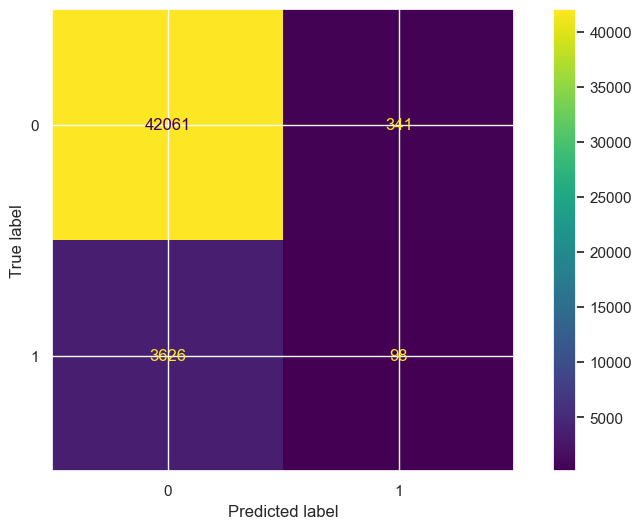

CPU times: total: 2min 11s
Wall time: 1min 50s


In [49]:
%%time

from sklearn.neighbors import KNeighborsClassifier
# Use the copy module of Python for deep copy operations
KNeighbors_pipe = deepcopy(intermediaire_pipeline)
KNeighbors_pipe.steps.append(['clf',KNeighborsClassifier(n_neighbors=5)])

#Compute AUC score
score_auc['KNeighbors'] = cross_validate(KNeighbors_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['KNeighbors']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['KNeighbors']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['KNeighbors']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, KNeighbors_pipe.fit(X_train, y_train).predict(X_test), labels=KNeighbors_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KNeighbors_pipe.classes_)
disp.plot()
plt.show()

### <a name="C3312"><font color='green'>III.3.12 Multi-Layer Perceptron Classifier</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.11%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.22%
L'entrainement s'exécute en moyenne en : 29s


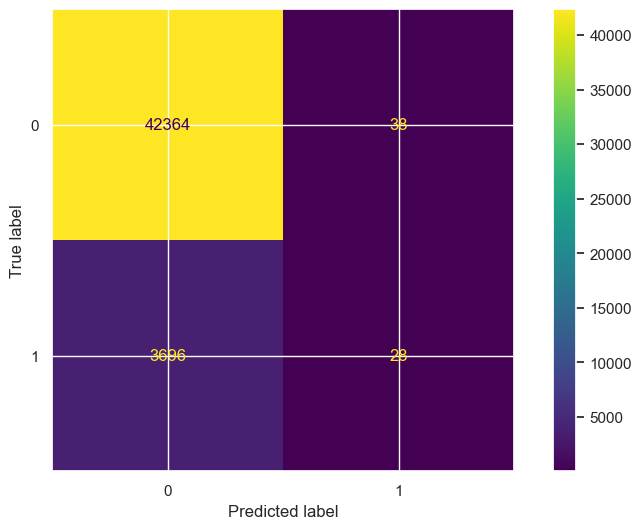

CPU times: total: 2min 20s
Wall time: 1min 1s


In [50]:
%%time

from sklearn.neural_network import MLPClassifier
# Use the copy module of Python for deep copy operations
MLPC_pipe = deepcopy(intermediaire_pipeline)
MLPC_pipe.steps.append(['clf',MLPClassifier(
    hidden_layer_sizes = (128,128,),
    activation = 'tanh',
    learning_rate = 'adaptive',
    max_iter = 10000,early_stopping=True,
    validation_fraction = 0.3,
    alpha=0.2
)])

#Compute AUC score
score_auc['MLPClassifier'] = cross_validate(MLPC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['MLPClassifier']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['MLPClassifier']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['MLPClassifier']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, MLPC_pipe.fit(X_train, y_train).predict(X_test), labels=MLPC_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MLPC_pipe.classes_)
disp.plot()
plt.show()

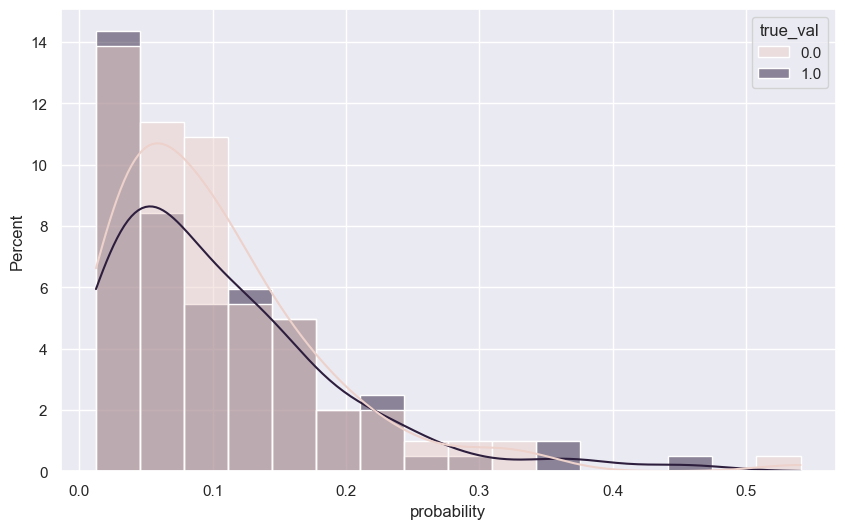

In [51]:
p_clf = pd.DataFrame(MLPC_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C3313"><font color='green'>III.3.13 Fit modeles</font></a>

#### <a name="C33131"><font color='green'>III.3.13.1 Fit modeles Raw</font></a>

In [52]:
%%time
train_test_valid_acc, train_test_valid_auc = dict(), dict()

for clf in [dummy_pipe,regLog_pipe,Ada_pipe,RF_pipe,HistGB_pipe,LGBM_pipe,MLPC_pipe]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                 )
         )
    
    train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [
        roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
        roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
        roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])]
    
    train_test_valid_acc[clf.steps[-1][1].__class__.__name__] = [
        balanced_accuracy_score(y_train, clf.predict(X_train) ),
        balanced_accuracy_score(y_validation, clf.predict(X_validation) ),
        balanced_accuracy_score(y_test, clf.predict(X_test) )]
    print("\n")

Entrainement du model: DummyClassifier en cours!
Scores obtenus sur les datasets
 Train: 50.0000% | Validation : 50.0000% | Test : 50.0000%


Entrainement du model: LogisticRegression en cours!
Scores obtenus sur les datasets
 Train: 73.8170% | Validation : 73.9515% | Test : 73.8935%


Entrainement du model: AdaBoostClassifier en cours!
Scores obtenus sur les datasets
 Train: 74.1092% | Validation : 74.1486% | Test : 74.2018%


Entrainement du model: RandomForestClassifier en cours!
Scores obtenus sur les datasets
 Train: 100.0000% | Validation : 72.2249% | Test : 72.4877%


Entrainement du model: HistGradientBoostingClassifier en cours!
Scores obtenus sur les datasets
 Train: 78.0233% | Validation : 74.9733% | Test : 74.6600%


Entrainement du model: LGBMClassifier en cours!
Scores obtenus sur les datasets
 Train: 78.8966% | Validation : 74.9956% | Test : 74.7626%


Entrainement du model: MLPClassifier en cours!
Scores obtenus sur les datasets
 Train: 73.3144% | Validation : 73.3045% 

In [53]:
%%time
for clf in [PAC_pipe,Perceptron_pipe,KNeighbors_pipe, LDA_pipe,]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    if (hasattr(clf, 'predict_proba') and callable(getattr(clf, 'predict_proba'))):
        print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
              .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                      roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                      roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                     )
             )
        train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [
            roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
            roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
            roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])]
        
        train_test_valid_acc[clf.steps[-1][1].__class__.__name__] = [
            balanced_accuracy_score(y_train, clf.predict(X_train) ),
            balanced_accuracy_score(y_validation, clf.predict(X_validation)),
            balanced_accuracy_score(y_test, clf.predict(X_test) )]
             
        print("\n")
        
    else:
        roc_auc_train = clf.decision_function(X_train)
        print('AttributeError: \'',clf.steps[-1][1].__class__.__name__,'\' object has no attribute \'predict_proba\'!!!')
        print("Scores accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
              .format(roc_auc_score(y_train, (clf.decision_function(X_train) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_validation, (clf.decision_function(X_validation) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_test, (clf.decision_function(X_test) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),   
                     )
             )
        train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [
            roc_auc_score(y_train, (clf.decision_function(X_train) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
            roc_auc_score(y_validation, (clf.decision_function(X_validation) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
            roc_auc_score(y_test, (clf.decision_function(X_test) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) )
        ]
        
        train_test_valid_acc[clf.steps[-1][1].__class__.__name__] = [
            balanced_accuracy_score(y_train, clf.predict(X_train) ),
            balanced_accuracy_score(y_validation, clf.predict(X_validation) ),
            balanced_accuracy_score(y_test, clf.predict(X_test) )]
        
        print("\n")

Entrainement du model: PassiveAggressiveClassifier en cours!
AttributeError: ' PassiveAggressiveClassifier ' object has no attribute 'predict_proba'!!!
Scores accuracy obtenus sur les datasets
 Train: 62.7972% | Validation : 62.3573% | Test : 63.2934%


Entrainement du model: Perceptron en cours!
AttributeError: ' Perceptron ' object has no attribute 'predict_proba'!!!
Scores accuracy obtenus sur les datasets
 Train: 56.2049% | Validation : 55.9062% | Test : 55.3972%


Entrainement du model: KNeighborsClassifier en cours!
Scores obtenus sur les datasets
 Train: 90.4258% | Validation : 58.5117% | Test : 57.7737%


Entrainement du model: LinearDiscriminantAnalysis en cours!
Scores obtenus sur les datasets
 Train: 73.7163% | Validation : 73.7917% | Test : 73.8054%


CPU times: total: 40min 45s
Wall time: 4min 16s


#### <a name="C33132"><font color='green'>III.3.13.2 Search Best modeles</font></a>

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

</Br>

</Br>

### <a name="C34"><font color='green'>III.4 Données déséquilibrées</font></a>

In [56]:
# pipeline data transformation imblearn
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as Pipeline_imb  # Importation de Pipeline depuis imblearn

In [57]:
%%time
from sklearn.compose import ColumnTransformer , make_column_selector

#Numerical featues
numeric_features = make_column_selector(dtype_include=np.number)
numeric_transformer = Pipeline_imb(
    steps=[("numScal",  StandardScaler()),
          ('impNumerical', SimpleImputer(strategy="median"))]
)

# categorials features
categorical_features = make_column_selector(dtype_include="object")
categorical_transformer = Pipeline_imb(
    steps=[
        ('impCat', SimpleImputer(strategy = 'most_frequent')),
    ])

# columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer, numeric_features),
        ("cat",  categorical_transformer, categorical_features),
    ])

# Pipeline initial
engeneringPipeline_1 = Pipeline_imb(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
engepipe1 = engeneringPipeline_1.fit(X_train)

# fit et transformation a partir du dataFrame X_train
X_train_res = pd.DataFrame(engepipe1.transform(X_train),columns=engepipe1.get_feature_names_out())

# transformation a partir du dataFrame X_test
X_test_res = pd.DataFrame(engepipe1.transform(X_test),columns=engepipe1.get_feature_names_out())

# transformation a partir du dataFrame X_test
X_validation_res = pd.DataFrame(engepipe1.transform(X_validation),columns=engepipe1.get_feature_names_out())

In [59]:
engepipe1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numScal',
                                                                   StandardScaler()),
                                                                  ('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002655668F580>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000265003311C0>)]))])

In [60]:
X_train_res.head()

,num__AMT_REQ_CREDIT_BUREAU_MON,num__FLAG_OWN_CAR,num__REG_CITY_NOT_WORK_CITY,num__REG_REGION_NOT_LIVE_REGION,num__REGION_POPULATION_RELATIVE,num__AMT_REQ_CREDIT_BUREAU_WEEK,num__REG_REGION_NOT_WORK_REGION,num__AMT_ANNUITY,num__DAYS_REGISTRATION,num__REGION_RATING_CLIENT_W_CITY,...,num__FLAG_DOCUMENT_3,num__FLAG_DOCUMENT_11,num__OBS_30_CNT_SOCIAL_CIRCLE,num__FLAG_PHONE,num__FLAG_DOCUMENT_6,cat__NAME_INCOME_TYPE,cat__NAME_EDUCATION_TYPE,cat__FONDKAPREMONT_MODE,cat__OCCUPATION_TYPE,cat__NAME_TYPE_SUITE
0,-0.290287,1.388434,-0.547572,-0.123911,0.309525,-0.167712,-0.230963,-0.119385,1.022546,-0.06114,...,0.639118,-0.062404,-0.172148,1.598155,-0.310015,Working,Secondary / secondary special,reg oper account,High skill tech staff,Unaccompanied
1,-0.290287,1.388434,-0.547572,-0.123911,0.309525,-0.167712,-0.230963,-0.288185,1.294713,-0.06114,...,-1.564655,-0.062404,-0.582871,-0.625722,-0.310015,Working,Secondary / secondary special,reg oper account,Laborers,Unaccompanied
2,-0.290287,1.388434,1.826244,-0.123911,1.830912,-0.167712,-0.230963,-0.306182,-0.570118,-2.050664,...,-1.564655,-0.062404,-0.172148,-0.625722,-0.310015,Commercial associate,Secondary / secondary special,reg oper account,Laborers,Unaccompanied
3,0.793513,1.388434,-0.547572,-0.123911,-0.012079,-0.167712,-0.230963,0.301374,0.557758,-2.050664,...,0.639118,-0.062404,3.113637,-0.625722,-0.310015,Working,Higher education,reg oper account,Laborers,Unaccompanied
4,-0.290287,-0.720236,-0.547572,-0.123911,-0.716342,-0.167712,-0.230963,0.639905,-0.014987,-0.06114,...,0.639118,-0.062404,-0.172148,-0.625722,-0.310015,Working,Secondary / secondary special,reg oper account,Laborers,"Spouse, partner"


In [61]:
X_test_res.head()

,num__AMT_REQ_CREDIT_BUREAU_MON,num__FLAG_OWN_CAR,num__REG_CITY_NOT_WORK_CITY,num__REG_REGION_NOT_LIVE_REGION,num__REGION_POPULATION_RELATIVE,num__AMT_REQ_CREDIT_BUREAU_WEEK,num__REG_REGION_NOT_WORK_REGION,num__AMT_ANNUITY,num__DAYS_REGISTRATION,num__REGION_RATING_CLIENT_W_CITY,...,num__FLAG_DOCUMENT_3,num__FLAG_DOCUMENT_11,num__OBS_30_CNT_SOCIAL_CIRCLE,num__FLAG_PHONE,num__FLAG_DOCUMENT_6,cat__NAME_INCOME_TYPE,cat__NAME_EDUCATION_TYPE,cat__FONDKAPREMONT_MODE,cat__OCCUPATION_TYPE,cat__NAME_TYPE_SUITE
0,-0.290287,-0.720236,-0.547572,-0.123911,-0.15023,-0.167712,-0.230963,-0.21961,-0.068398,-0.06114,...,0.639118,-0.062404,-0.582871,1.598155,-0.310015,Working,Secondary / secondary special,reg oper account,Laborers,Unaccompanied
1,-0.290287,-0.720236,-0.547572,-0.123911,1.830912,-0.167712,-0.230963,0.850595,0.624238,-2.050664,...,0.639118,-0.062404,-0.582871,-0.625722,-0.310015,Working,Incomplete higher,reg oper account,Core staff,Unaccompanied
2,-0.290287,-0.720236,-0.547572,-0.123911,0.309525,-0.167712,-0.230963,-0.701498,0.972828,-0.06114,...,0.639118,-0.062404,-0.172148,1.598155,-0.310015,Working,Secondary / secondary special,reg oper account,Low-skill Laborers,Unaccompanied
3,-0.290287,1.388434,-0.547572,-0.123911,-0.994232,-0.167712,-0.230963,2.716395,1.099821,-0.06114,...,0.639118,-0.062404,-0.582871,-0.625722,-0.310015,Commercial associate,Higher education,reg oper account,Core staff,Unaccompanied
4,-0.290287,1.388434,-0.547572,-0.123911,0.398253,-0.167712,-0.230963,-0.626717,0.91544,-0.06114,...,0.639118,-0.062404,0.238575,1.598155,-0.310015,Working,Secondary / secondary special,reg oper account,Sales staff,Family


In [62]:
%%time
# Importation du package
from imblearn.over_sampling import SMOTENC

# Définition de l'instance SMOTE où 1 désigne la colonne catégorielle
ind_cat = [ i for i, word in enumerate(X_train_res.columns) if word.startswith('cat') ]
smote_nc = SMOTENC(categorical_features = ind_cat, sampling_strategy=0.5, k_neighbors=3)

# Application du SMOTE aux données
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train_res, y_train)

CPU times: total: 7min 25s
Wall time: 48.4 s


In [63]:
X_train_smote.shape, X_train.shape, 

((296815, 39), (215254, 39))

In [64]:
y_train_smote.mean(), y_train.mean()

(0.33333221029934473, 0.08072788426695904)

In [65]:
numeric_features = [word for word in X_train_res.columns if word.startswith('num__') ]
categorical_features = [word for word in X_train_res.columns if word.startswith('cat__') ]

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

# ColumnTransformer pour appliquer les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],remainder='passthrough'
)

# Appliquer les transformations sur les données
X_train_smoteOHE = preprocessor.fit_transform(X_train_smote)
X_test_smoteOHE = preprocessor.transform(X_test_res)
X_validation_smoteOHE = preprocessor.transform(X_validation_res)

# Convertir les données transformées en DataFrame pour visualisation
X_train_smoteOHE = pd.DataFrame(X_train_smoteOHE, columns=
    numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

X_test_smoteOHE = pd.DataFrame(X_test_smoteOHE, columns=
    numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

X_validation_smoteOHE = pd.DataFrame(X_validation_smoteOHE, columns=
    numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

X_test_smoteOHE_equil = pd.concat([X_test_smoteOHE.iloc[idx_risk,:],
                          X_test_smoteOHE.iloc[idx_bon,:] ],axis=0)

#### Regression logistique Smote

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 78.90%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 71.86%
L'entrainement s'exécute en moyenne en : 5s


Scores auc obtenus sur les datasets
 Train: 79.3397% | Validation : 70.4595% | Test : 70.3640%
Scores balanced accuracy obtenus sur les datasets
 Train: 72.2036% | Validation : 65.4052% | Test : 64.5335%


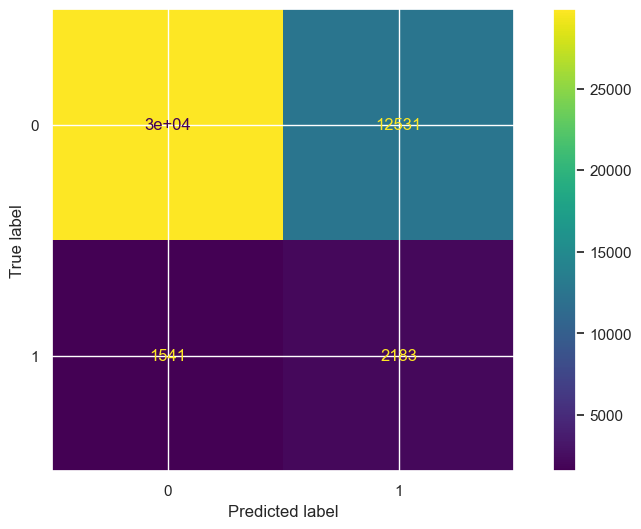

CPU times: total: 22.6 s
Wall time: 30.2 s


In [66]:
%%time
# Use the copy module of Python for deep copy operations
regLog_smote = LogisticRegression(class_weight='balanced')

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_Smote'] = cross_validate(regLog_smote, X_train_smoteOHE, y_train_smote, 
                                           cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])


# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Smote']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Smote']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Smote']['fit_time'].mean(),4)))

print("\n")
regLog_smote.fit( X_train_smoteOHE, y_train_smote )
print("Scores auc obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train_smote, regLog_smote.predict_proba(X_train_smoteOHE)[:, 1]),
              roc_auc_score(y_validation, regLog_smote.predict_proba(X_validation_smoteOHE)[:, 1]),
              roc_auc_score(y_test, regLog_smote.predict_proba(X_test_smoteOHE)[:, 1])
             )
     )


print("Scores balanced accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(balanced_accuracy_score(y_train_smote, regLog_smote.predict(X_train_smoteOHE) ),
              balanced_accuracy_score(y_validation, regLog_smote.predict(X_validation_smoteOHE) ),
              balanced_accuracy_score(y_test, regLog_smote.predict(X_test_smoteOHE) )
             )
     )

cm = confusion_matrix(y_test, regLog_smote.predict(X_test_smoteOHE), labels=regLog_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regLog_smote.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Count'>

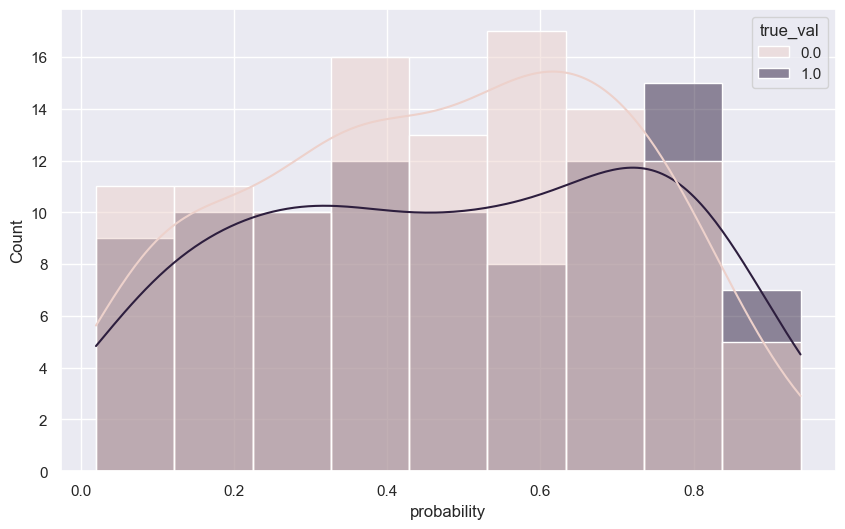

In [67]:
p_clf = pd.DataFrame(regLog_smote.predict_proba(X_test_smoteOHE_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde = True)

In [68]:
## auc
train_test_valid_auc['RegLog_Smote'] = [
    roc_auc_score(y_train_smote, regLog_smote.predict_proba(X_train_smoteOHE)[:, 1]),
    roc_auc_score(y_validation, regLog_smote.predict_proba(X_validation_smoteOHE)[:, 1]),
    roc_auc_score(y_test, regLog_smote.predict_proba(X_test_smoteOHE)[:, 1])
]


## accuracy
train_test_valid_acc['RegLog_Smote'] = [
    balanced_accuracy_score(y_train_smote, regLog_smote.predict(X_train_smoteOHE) ),
    balanced_accuracy_score(y_validation, regLog_smote.predict(X_validation_smoteOHE) ),
    balanced_accuracy_score(y_test, regLog_smote.predict(X_test_smoteOHE) )
]

#### HistGradientBoostingClassifier Smote

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 93.21%
L'accuracy moyenne pondérée obtenu à partir du dataset d'entrainement est: 71.94%
L'entrainement s'exécute en moyenne en : 18s


Scores auc obtenus sur les datasets
 Train: 94.7682% | Validation : 73.0501% | Test : 72.7698%
Scores balanced accuracy obtenus sur les datasets
 Train: 75.5626% | Validation : 66.4611% | Test : 66.1715%


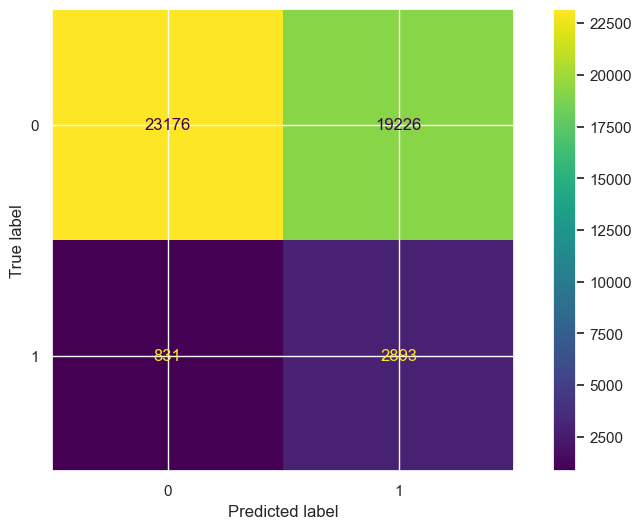

CPU times: total: 1min 30s
Wall time: 45.6 s


In [69]:
%%time
# Use the copy module of Python for deep copy operations
Histgbm_smote = HistGradientBoostingClassifier(class_weight = {0:1/11.3869, 1:1}) #scale_pos_weight = 11.3869


#Compute AUC score
score_auc['HistGBM_Smote'] = cross_validate(Histgbm_smote,
                                            X_train_smoteOHE, 
                                            y_train_smote,
                                            cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])


# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGBM_Smote']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("L'accuracy moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGBM_Smote']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGBM_Smote']['fit_time'].mean(),4)))

print("\n")
Histgbm_smote.fit( X_train_smoteOHE, y_train_smote )
print("Scores auc obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train_smote, Histgbm_smote.predict_proba(X_train_smoteOHE)[:, 1]),
              roc_auc_score(y_validation, Histgbm_smote.predict_proba(X_validation_smoteOHE)[:, 1]),
              roc_auc_score(y_test, Histgbm_smote.predict_proba(X_test_smoteOHE)[:, 1])
             )
     )


print("Scores balanced accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(balanced_accuracy_score(y_train_smote, Histgbm_smote.predict(X_train_smoteOHE) ),
              balanced_accuracy_score(y_validation, Histgbm_smote.predict(X_validation_smoteOHE) ),
              balanced_accuracy_score(y_test, Histgbm_smote.predict(X_test_smoteOHE) )
             )
     )

cm = confusion_matrix(y_test, Histgbm_smote.predict(X_test_smoteOHE), labels= Histgbm_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Histgbm_smote.classes_)
disp.plot()
plt.show()

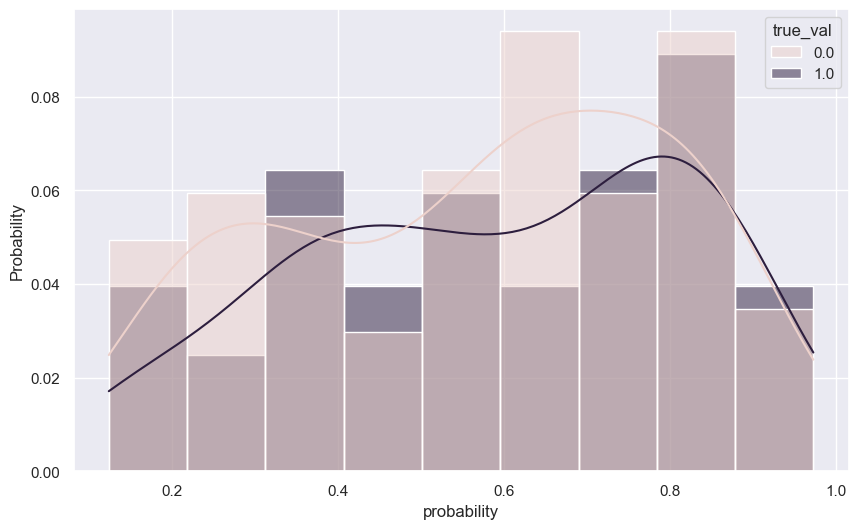

In [81]:
p_clf = pd.DataFrame(Histgbm_smote.predict_proba(X_test_smoteOHE_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde = True,stat='probability');

In [71]:
## auc
train_test_valid_auc['HistGBM_Smote'] = [
    roc_auc_score(y_train_smote, Histgbm_smote.predict_proba(X_train_smoteOHE)[:, 1]),
    roc_auc_score(y_validation, Histgbm_smote.predict_proba(X_validation_smoteOHE)[:, 1]),
    roc_auc_score(y_test, Histgbm_smote.predict_proba(X_test_smoteOHE)[:, 1])
]


## accuracy
train_test_valid_acc['HistGBM_Smote'] = [
    balanced_accuracy_score(y_train_smote, Histgbm_smote.predict(X_train_smoteOHE) ),
    balanced_accuracy_score(y_validation, Histgbm_smote.predict(X_validation_smoteOHE) ),
    balanced_accuracy_score(y_test, Histgbm_smote.predict(X_test_smoteOHE) )
]

#### LightGBM Smote

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 93.39%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 71.86%
L'entrainement s'exécute en moyenne en : 5s


Scores auc obtenus sur les datasets
 Train: 95.2010% | Validation : 73.3577% | Test : 73.2686%
Scores balanced accuracy obtenus sur les datasets
 Train: 76.6226% | Validation : 66.9339% | Test : 66.4637%


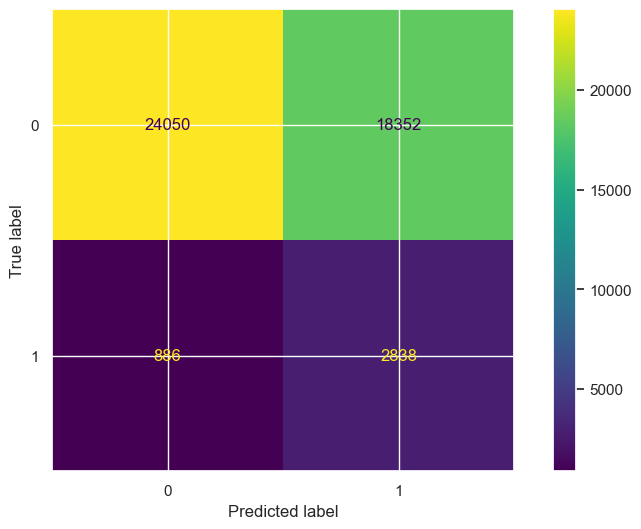

CPU times: total: 37.3 s
Wall time: 16.1 s


In [72]:
%%time
# Use the copy module of Python for deep copy operations
lightgbm_smote = lgbmc(scale_pos_weight = 11.3869)


#Compute AUC score
score_auc['lightgb_Smote'] = cross_validate(lightgbm_smote,X_train_smoteOHE.values, y_train_smote,
                                            cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])


# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['lightgb_Smote']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['lightgb_Smote']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['lightgb_Smote']['fit_time'].mean(),4)))

print("\n")
lightgbm_smote.fit( X_train_smoteOHE.values, y_train_smote )
print("Scores auc obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train_smote, lightgbm_smote.predict_proba(X_train_smoteOHE.values)[:, 1]),
              roc_auc_score(y_validation, lightgbm_smote.predict_proba(X_validation_smoteOHE.values)[:, 1]),
              roc_auc_score(y_test, lightgbm_smote.predict_proba(X_test_smoteOHE.values)[:, 1])
             )
     )


print("Scores balanced accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(balanced_accuracy_score(y_train_smote, lightgbm_smote.predict(X_train_smoteOHE.values) ),
              balanced_accuracy_score(y_validation, lightgbm_smote.predict(X_validation_smoteOHE.values) ),
              balanced_accuracy_score(y_test, lightgbm_smote.predict(X_test_smoteOHE.values) )
             )
     )

cm = confusion_matrix(y_test, lightgbm_smote.predict(X_test_smoteOHE.values), labels=Histgbm_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Histgbm_smote.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Count'>

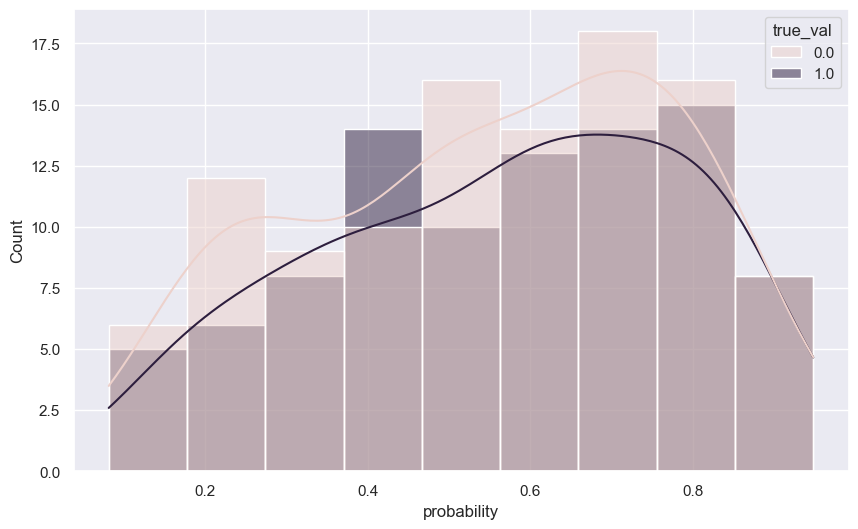

In [73]:
p_clf = pd.DataFrame(lightgbm_smote.predict_proba(X_test_smoteOHE_equil.values)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde = True)

In [74]:
## auc
train_test_valid_auc['lightgb_smote'] = [
    roc_auc_score(y_train_smote, lightgbm_smote.predict_proba(X_train_smoteOHE.values)[:, 1]),
    roc_auc_score(y_validation, lightgbm_smote.predict_proba(X_validation_smoteOHE.values)[:, 1]),
    roc_auc_score(y_test, lightgbm_smote.predict_proba(X_test_smoteOHE.values)[:, 1])
]


## accuracy
train_test_valid_acc['lightgb_smote'] = [
    balanced_accuracy_score(y_train_smote, lightgbm_smote.predict(X_train_smoteOHE.values) ),
    balanced_accuracy_score(y_validation, lightgbm_smote.predict(X_validation_smoteOHE.values) ),
    balanced_accuracy_score(y_test, lightgbm_smote.predict(X_test_smoteOHE.values) )
]

### <a name="C35"><font color='green'>III.5 Comparaison des modeles</font></a>

In [75]:
pd.DataFrame(score_auc).applymap(lambda x: np.round(x.mean(),5) )\
.T.sort_values(by = 'test_balanced_accuracy', ascending = False)

,fit_time,score_time,test_roc_auc,test_balanced_accuracy
HistGBM_Smote,18.15730,2.62019,0.93213,0.71941
RegLog_Smote,5.75710,0.32307,0.78900,0.71858
lightgb_Smote,5.11776,0.87140,0.93388,0.71858
HistGradientBoosting,10.40935,1.35311,0.74387,0.68145
LightGBM,2.37914,0.37168,0.74442,0.68059
RegLog_classweight,3.53040,0.23245,0.73637,0.67471
Perceptron,2.55558,0.22225,0.59680,0.57278
Passive Aggressive,2.41435,0.23065,0.59267,0.52837
KNeighbors,1.32970,93.82089,0.58213,0.50989
Adaboost,27.19934,2.16329,0.73671,0.50895


In [76]:
pd.DataFrame(train_test_valid_auc,index=['Train','Test','Validation']).T\
.sort_values(by = 'Validation', ascending = False)\
.applymap(lambda x: np.round(x,4) )

,Train,Test,Validation
LGBMClassifier,0.7890,0.7500,0.7476
HistGradientBoostingClassifier,0.7802,0.7497,0.7466
AdaBoostClassifier,0.7411,0.7415,0.7420
LogisticRegression,0.7382,0.7395,0.7389
LinearDiscriminantAnalysis,0.7372,0.7379,0.7381
MLPClassifier,0.7331,0.7330,0.7335
lightgb_smote,0.9520,0.7336,0.7327
HistGBM_Smote,0.9477,0.7305,0.7277
RandomForestClassifier,1.0000,0.7222,0.7249
RegLog_Smote,0.7934,0.7046,0.7036


In [77]:
pd.DataFrame(train_test_valid_acc,index=['accuracy Train','accuracy Test','accuracy Validation']).T\
.sort_values(by = 'accuracy Validation', ascending = False)\
.applymap(lambda x: np.round(x,4) )

,accuracy Train,accuracy Test,accuracy Validation
HistGradientBoostingClassifier,0.7066,0.6880,0.6835
LGBMClassifier,0.7122,0.6879,0.6831
LogisticRegression,0.6760,0.6801,0.6771
lightgb_smote,0.7662,0.6693,0.6646
HistGBM_Smote,0.7556,0.6646,0.6617
RegLog_Smote,0.7220,0.6541,0.6453
PassiveAggressiveClassifier,0.5484,0.5512,0.5538
Perceptron,0.5395,0.5402,0.5363
KNeighborsClassifier,0.5468,0.5083,0.5091
LinearDiscriminantAnalysis,0.5086,0.5095,0.5081


## Pipe smote

In [121]:
class PandasTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = pd.DataFrame( X,columns=['num__AMT_REQ_CREDIT_BUREAU_MON', 'num__FLAG_OWN_CAR',
       'num__REG_CITY_NOT_WORK_CITY', 'num__REG_REGION_NOT_LIVE_REGION',
       'num__REGION_POPULATION_RELATIVE',
       'num__AMT_REQ_CREDIT_BUREAU_WEEK',
       'num__REG_REGION_NOT_WORK_REGION', 'num__AMT_ANNUITY',
       'num__DAYS_REGISTRATION', 'num__REGION_RATING_CLIENT_W_CITY',
       'num__FLAG_DOCUMENT_5', 'num__AMT_INCOME_TOTAL',
       'num__FLAG_OWN_REALTY', 'num__FLAG_DOCUMENT_13',
       'num__AMT_REQ_CREDIT_BUREAU_YEAR', 'num__DAYS_ID_PUBLISH',
       'num__AMT_REQ_CREDIT_BUREAU_HOUR', 'num__FLAG_WORK_PHONE',
       'num__DAYS_BIRTH', 'num__DEF_30_CNT_SOCIAL_CIRCLE',
       'num__EXT_SOURCE_3', 'num__EXT_SOURCE_2',
       'num__DAYS_LAST_PHONE_CHANGE', 'num__FLAG_EMAIL',
       'num__FLAG_DOCUMENT_9', 'num__CODE_GENDER', 'num__DAYS_EMPLOYED',
       'num__REG_CITY_NOT_LIVE_CITY', 'num__AMT_GOODS_PRICE',
       'num__FLAG_DOCUMENT_3', 'num__FLAG_DOCUMENT_11',
       'num__OBS_30_CNT_SOCIAL_CIRCLE', 'num__FLAG_PHONE',
       'num__FLAG_DOCUMENT_6', 'cat__NAME_INCOME_TYPE',
       'cat__NAME_EDUCATION_TYPE', 'cat__FONDKAPREMONT_MODE',
       'cat__OCCUPATION_TYPE', 'cat__NAME_TYPE_SUITE']).copy()
        return cpy_df

    def fit(self, X, y=None):
        return self

In [124]:
engepipe_smote = deepcopy(engepipe1)
# transform into pd.Dataframe
engepipe_smote.steps.append(['to_pandas',PandasTransformer()])
# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
engepipe_smote.steps.append(['ohe',preprocessor])

regLog_smote_pipe = deepcopy(engepipe_smote)
regLog_smote_pipe.steps.append(['clf',regLog_smote])

HistGB_smote_pipe = deepcopy(engepipe_smote)
HistGB_smote_pipe.steps.append(['clf',Histgbm_smote])
LGBM_smote_pipe = deepcopy(engepipe_smote)
LGBM_smote_pipe.steps.append(['clf',lightgbm_smote])

In [125]:
HistGB_smote_pipe.predict(X_test)

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

### <font color='green'> _**LogisticRegression est le meilleur model**_ </font> 

In [115]:
from sklearn.metrics import roc_curve
def generate_auc_roc_curve(clf, X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label = clf.steps[-1][1].__class__.__name__+': AUC ='+str(auc))
    plt.legend(loc=4)
    pass


def generate_auc_roc_curve_smote(clf, X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label = clf.__class__.__name__+': AUC ='+str(auc))
    plt.legend(loc=4)
    pass

CPU times: total: 2.77 s
Wall time: 535 ms


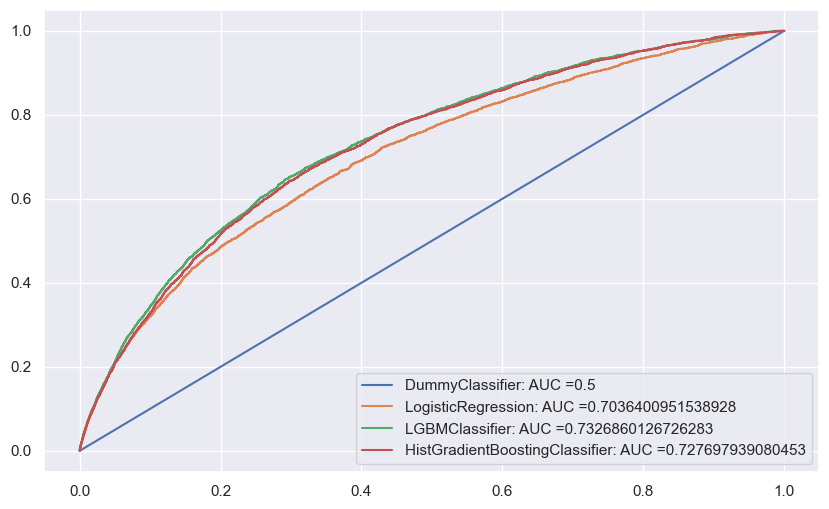

In [126]:
%%time
generate_auc_roc_curve(dummy_pipe,X_test,y_test)
generate_auc_roc_curve_smote(regLog_smote,X_test_smoteOHE,y_test)
generate_auc_roc_curve_smote(lightgbm_smote,X_test_smoteOHE.values,y_test)
generate_auc_roc_curve_smote(Histgbm_smote, X_test_smoteOHE,y_test)

CPU times: total: 2min 6s
Wall time: 13.3 s


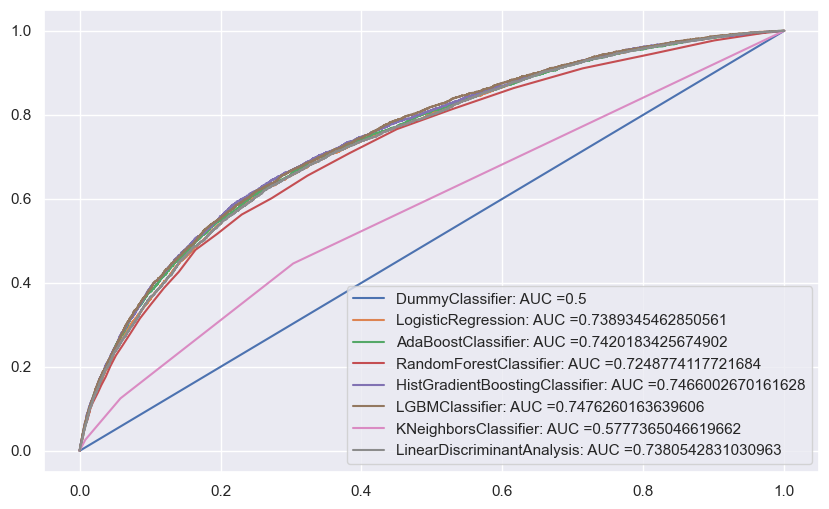

In [79]:
%%time
generate_auc_roc_curve(dummy_pipe,X_test,y_test)
generate_auc_roc_curve(regLog_pipe,X_test,y_test)
generate_auc_roc_curve(Ada_pipe,X_test,y_test)
generate_auc_roc_curve(RF_pipe,X_test,y_test)
generate_auc_roc_curve(HistGB_pipe,X_test,y_test)
generate_auc_roc_curve(LGBM_pipe,X_test,y_test)
#generate_auc_roc_curve(GradientBoosting_pipe,X_test,y_test)

generate_auc_roc_curve(KNeighbors_pipe,X_test,y_test)
generate_auc_roc_curve(LDA_pipe,X_test,y_test)

#AttributeError: 'Perceptron' object has no attribute 'predict_proba'
#generate_auc_roc_curve(Perceptron_pipe,X_test,y_test)

## <a name="C4"><font color='purple'>IV. Sauvegarde des models</font></a>

In [127]:
import joblib
joblib.dump(dummy_pipe, "data/modeles sauvegardés/DummyClassifer_model.sav")
joblib.dump(regLog_pipe,"data/modeles sauvegardés/LogisticRegression_model.sav")
joblib.dump(Ada_pipe,"data/modeles sauvegardés/AdaBoostClassifier_model.sav")
joblib.dump(RF_pipe,"data/modeles sauvegardés/RandomForestClassifier_model.sav")
joblib.dump(HistGB_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
joblib.dump(LGBM_pipe,"data/modeles sauvegardés/lightGBMClasiifer_model.sav")
joblib.dump(GradientBoosting_pipe,"data/modeles sauvegardés/GradientBoostingClassifier_model.sav")
joblib.dump(MLPC_pipe, "data/modeles sauvegardés/MultiLayerPerceptronClassifier_model.sav")
joblib.dump(KNeighbors_pipe,  "data/modeles sauvegardés/KNeighborsClassifier_model.sav")
joblib.dump(LDA_pipe, "data/modeles sauvegardés/DiscriminanteAnalysisLineaire_model.sav")
joblib.dump(PAC_pipe, "data/modeles sauvegardés/PassiveAggressiveClassifier_model.sav")
joblib.dump(Perceptron_pipe, "data/modeles sauvegardés/simplePerceptronClassifier_model.sav")



joblib.dump(regLog_smote_pipe,"data/modeles sauvegardés/LogisticRegression_smote_model.sav")
joblib.dump(HistGB_smote_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_smote_model.sav")
joblib.dump(LGBM_smote_pipe,"data/modeles sauvegardés/lightGBMClasiifer_smote_model.sav")

# Model de traitement des données
joblib.dump(intermediaire_pipeline, "data/modeles sauvegardés/intermediaire_pipeline.sav")

['data/modeles sauvegardés/intermediaire_pipeline.sav']

In [128]:
gc.collect()

29558

## <a name="C5"><font color='blue'>V. MLflow</font></a>

In [129]:
import mlflow

In [130]:
def eval_metrics(actual, pred, pred_proba):
    accuracy = balanced_accuracy_score(actual, pred)
    precision = precision_score(actual, pred )
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    auc = roc_auc_score(actual, pred_proba[:,1])
    return accuracy, precision, f1, recall, auc

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### <a name="C50"><font color='blue'>V.0 Setting mlflow </font></a>

### infer_signature
Les signatures de modèle définissent les schémas d'entrée et de sortie pour les modèles MLflow, fournissant une interface standard pour codifier et appliquer l'utilisation correcte de vos modèles. 

Les signatures sont récupérées par l'interface utilisateur de suivi MLflow et l'interface utilisateur du registre de modèles pour afficher les entrées et les sorties du modèle. 

Ils sont également utilisés par les outils de déploiement de modèle MLflow pour valider les entrées d'inférence en fonction de la signature attribuée au modèle.

In [131]:
from mlflow.models import infer_signature
signature = infer_signature(X_train,y_train)

### <a name="C51"><font color='blue'>V.1 Tracking mlflow </font></a>

MLflow Tracking est l'API et l'interface utilisateur pour logger 
* les hyper-paramètres, 
* le versioning de code, 
* les artifacts (configuration du modèle, fichier de poids, ...).

In [132]:
# Définir où les Runs sont enregistrées local ou remote
mlflow.set_tracking_uri("data/mlflow/mlruns") 

# Définir l'expérience donnée comme l'expérience active.
# Définir un nom d'expérience, qui doit être unique et sensible à la casse.
# 'OC_projet_7' : path to experiment in remote workspace
mlflow.set_experiment('OC_projet_7') 

# Active (ou désactive) et configure l'autologisation pour les estimateurs scikit-learn.
mlflow.sklearn.autolog(exclusive=False)# Permet de faire appel à l'API de sklearn qui integre tous les algorithme de scikit-learn

2023/09/06 14:18:46 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002653165D610>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/09/06 14:18:46 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

accuracy : 0.5 | precision : 0.0 | f1 : 0.0 | recall : 0.0 | auc : 0.5
AUC: 0.5
CPU times: total: 5.44 s
Wall time: 10.2 s


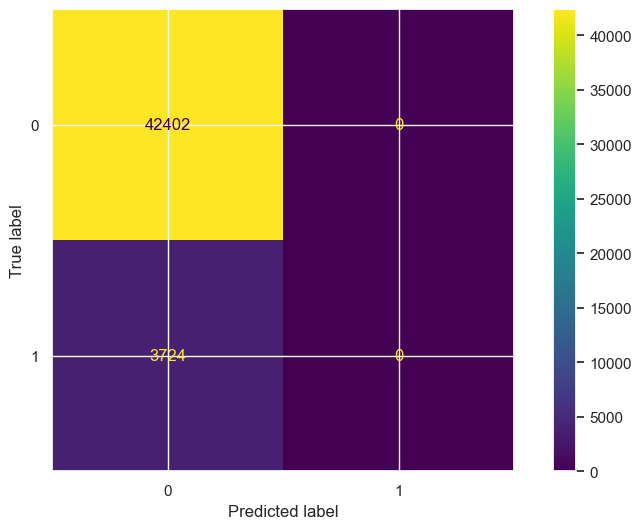

In [133]:
%%time

# Dummy estimator
with mlflow.start_run(run_name='Dummy_Estimator'): #experiment_id= experiment_id
    dummy_pipe.fit(X_train, y_train)
    
    y_pred_proba = dummy_pipe.predict_proba(X_test)
    y_pred = dummy_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {} | precision : {} | f1 : {} | recall : {} | auc : {}".format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(dummy_pipe, 'pipeline Dummy Estimator', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

2023/09/06 14:21:11 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002655668FF40>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/09/06 14:21:11 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

accuracy : 50.27% | precision : 41.07% | f1 : 1.22% | recall : 0.62% | auc : 73.90%
AUC: 0.7389990534058164
CPU times: total: 7.25 s
Wall time: 11.5 s


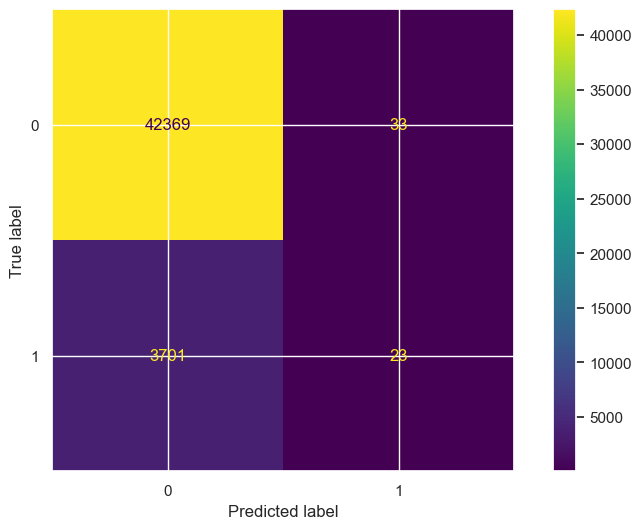

In [135]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_0'): #experiment_id= experiment_id
    regLog_pipe_raw.fit(X_train, y_train)
    
    y_pred_proba = regLog_pipe_raw.predict_proba(X_test)
    y_pred = regLog_pipe_raw.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.2%} | precision : {:.2%} | f1 : {:.2%} | recall : {:.2%} | auc : {:.2%}".format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe_raw, 'pipeline Regression Logistic', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}
    run_idrlog = mlflow.active_run().info.run_id

2023/09/06 14:24:44 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026564AE0760>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/09/06 14:24:44 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

accuracy : 67.709% | precision : 15.670% | f1 : 25.412% | recall : 67.159% | auc : 73.893%
AUC: 0.7389345462850561
CPU times: total: 6.97 s
Wall time: 11.3 s


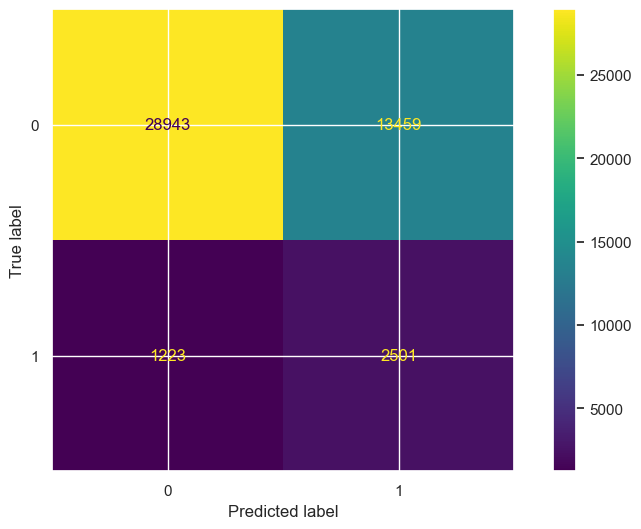

In [136]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_balanced'): #experiment_id= experiment_id
    regLog_pipe.fit(X_train, y_train)
    
    y_pred_proba = regLog_pipe.predict_proba(X_test)
    y_pred = regLog_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe, 'pipeline Regression Logistic balanced', signature=signature)
    run_idrlog = mlflow.active_run().info.run_id

2023/09/06 14:27:15 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026564AE0760>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/09/06 14:27:15 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

accuracy : 64.533% | precision : 14.836% | f1 : 23.679% | recall : 58.620% | auc : 70.364%
AUC: 0.7036400951538928
CPU times: total: 7.36 s
Wall time: 11.7 s


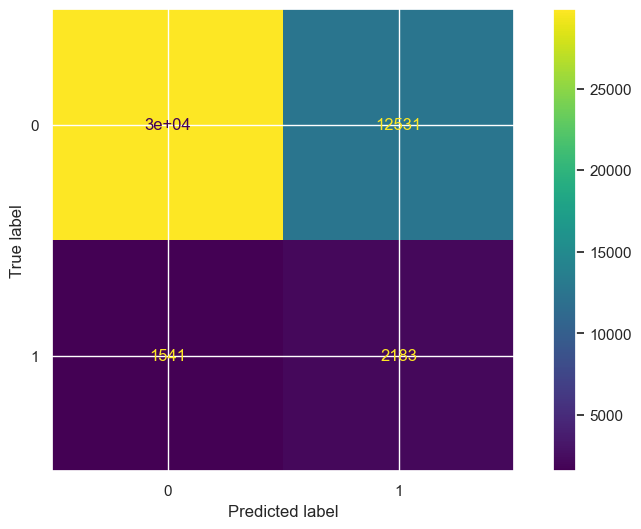

In [137]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_smote'): #experiment_id= experiment_id
    regLog_pipe.fit(X_train, y_train)
    
    y_pred_proba = regLog_smote_pipe.predict_proba(X_test)
    y_pred = regLog_smote_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_smote_pipe, 'pipeline Regression Logistic smote', signature=signature)
    run_idrlog = mlflow.active_run().info.run_id

2023/09/06 14:29:10 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000265652325B0>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/09/06 14:29:10 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

accuracy : 68.476% | precision : 16.277% | f1 : 26.221% | recall : 67.401% | auc : 74.662%
AUC: 0.7466185754872131


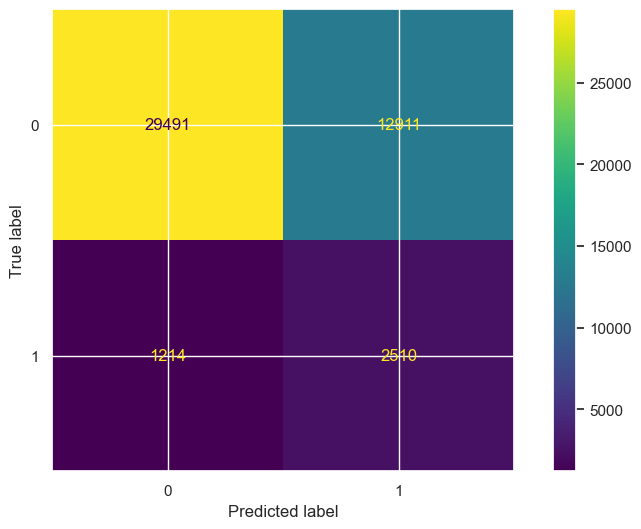

In [138]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting_0'): #experiment_id= experiment_id
    HistGB_pipe.fit(X_train, y_train)
    
    y_pred_proba = HistGB_pipe.predict_proba(X_test)
    y_pred = HistGB_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_pipe, 'pipeline HistGradient Boosting', signature=signature)   
    run_idHistGB = mlflow.active_run().info.run_id

2023/09/06 14:41:21 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/06 14:41:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/09/06 14:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID a927e73af6a340c98321bfcef45aab39. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'verbose\' was already logged with value=\'False\' for run ID=\'a927e73af6a340c98321bfcef45aab39\'. Attempted logging new value \'0\'.")]')]


accuracy : 68.347% | precision : 16.367% | f1 : 26.275% | recall : 66.568% | auc : 74.736%
AUC: 0.7473625289040792


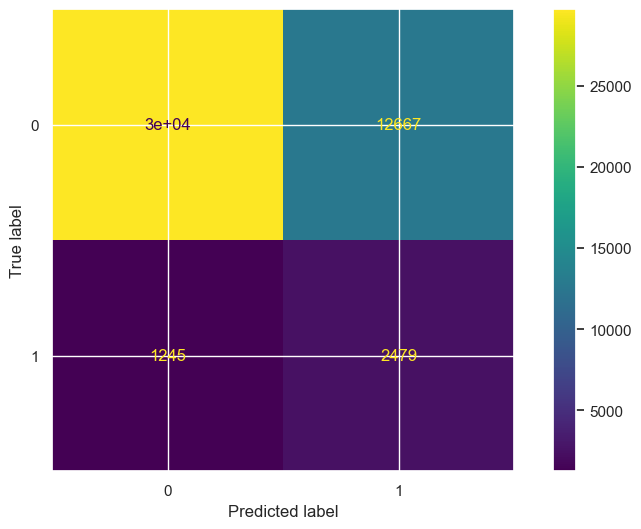

In [139]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting_smote'): #experiment_id= experiment_id
    HistGB_smote_pipe.fit(X_train, y_train)
    
    y_pred_proba = HistGB_smote_pipe.predict_proba(X_test)
    y_pred = HistGB_smote_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}"\
          .format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_smote_pipe, 'pipeline HistGradient Boosting smote', signature=signature)   
    run_idHistGB = mlflow.active_run().info.run_id

2023/09/06 14:43:14 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026563D64730>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/09/06 14:43:14 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

accuracy : 68.311% | precision : 16.195% | f1 : 26.095% | recall : 67.132% | auc : 74.763%
AUC: 0.7476260163639606


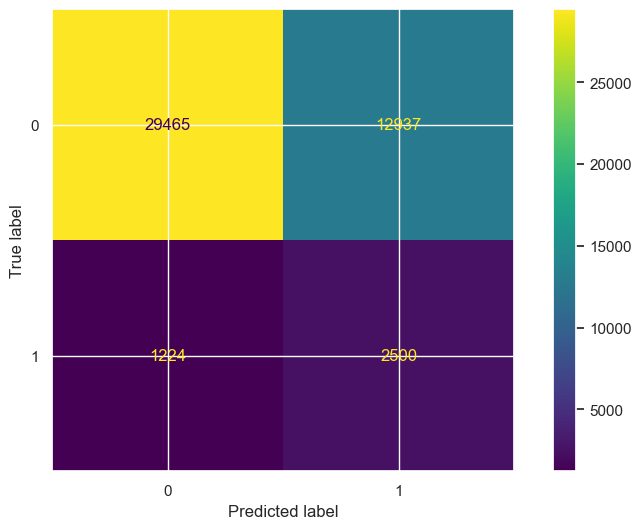

In [141]:
# premier run
with mlflow.start_run(run_name='LightGBM_0'): #experiment_id= experiment_id
    LGBM_pipe.fit(X_train, y_train)
    
    y_pred_proba = LGBM_pipe.predict_proba(X_test)
    y_pred = LGBM_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}"\
          .format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)

    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(LGBM_pipe, 'pipeline Light Gradient Boosting', signature=signature)
    run_idlgbm = mlflow.active_run().info.run_id

2023/09/06 14:45:51 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/06 14:45:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


accuracy : 68.405% | precision : 16.200% | f1 : 26.126% | recall : 67.454% | auc : 74.713%
AUC: 0.7471331125525511


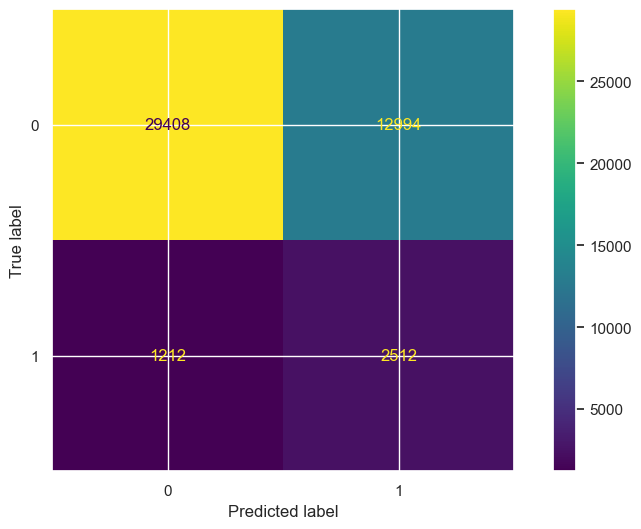

In [142]:
# premier run
with mlflow.start_run(run_name='LightGBM_smote'): #experiment_id= experiment_id
    LGBM_smote_pipe.fit(X_train, y_train)
    
    y_pred_proba = LGBM_smote_pipe.predict_proba(X_test)
    y_pred = LGBM_smote_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}"\
          .format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)

    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(LGBM_smote_pipe, 'pipeline Light Gradient Boosting smote', signature=signature)
    run_idlgbm = mlflow.active_run().info.run_id

</Br>

</Br>

### <a name="C52"><font color='blue'>V.2 Model Registry (Registre de modèle) </font></a>

Le Model Registry (registre de modèles) est un composant de MLflow qui permet de gérer des versions de modèles de Machine Learning, en proposant également des stages (états).

* Le tag staging correspond à un modèle considéré comme pré-production.
* Le tag production correspond à un modèle qui serait en environnement de production.
* Le tag archived pour les anciens modèles archivés.

C'est un composant particulièrement utile pour gérer le cycle de vie des modèles, car le cycle staging, production et archive est couramment appliqué lorsque des modèles sont mis à jour régulièrement. Sous MLflow, l'onglet Models permet d'afficher tous les modèles enregistrés.

###  Enregistrement d'un modèle</font></Br>
1. Dans la page de détail des exécutions MLflow, sélectionnez un modèle MLflow enregistré dans la section Artefacts.</Br>
2. Cliquez sur le bouton Enregistrer le modèle .
</Br></Br>
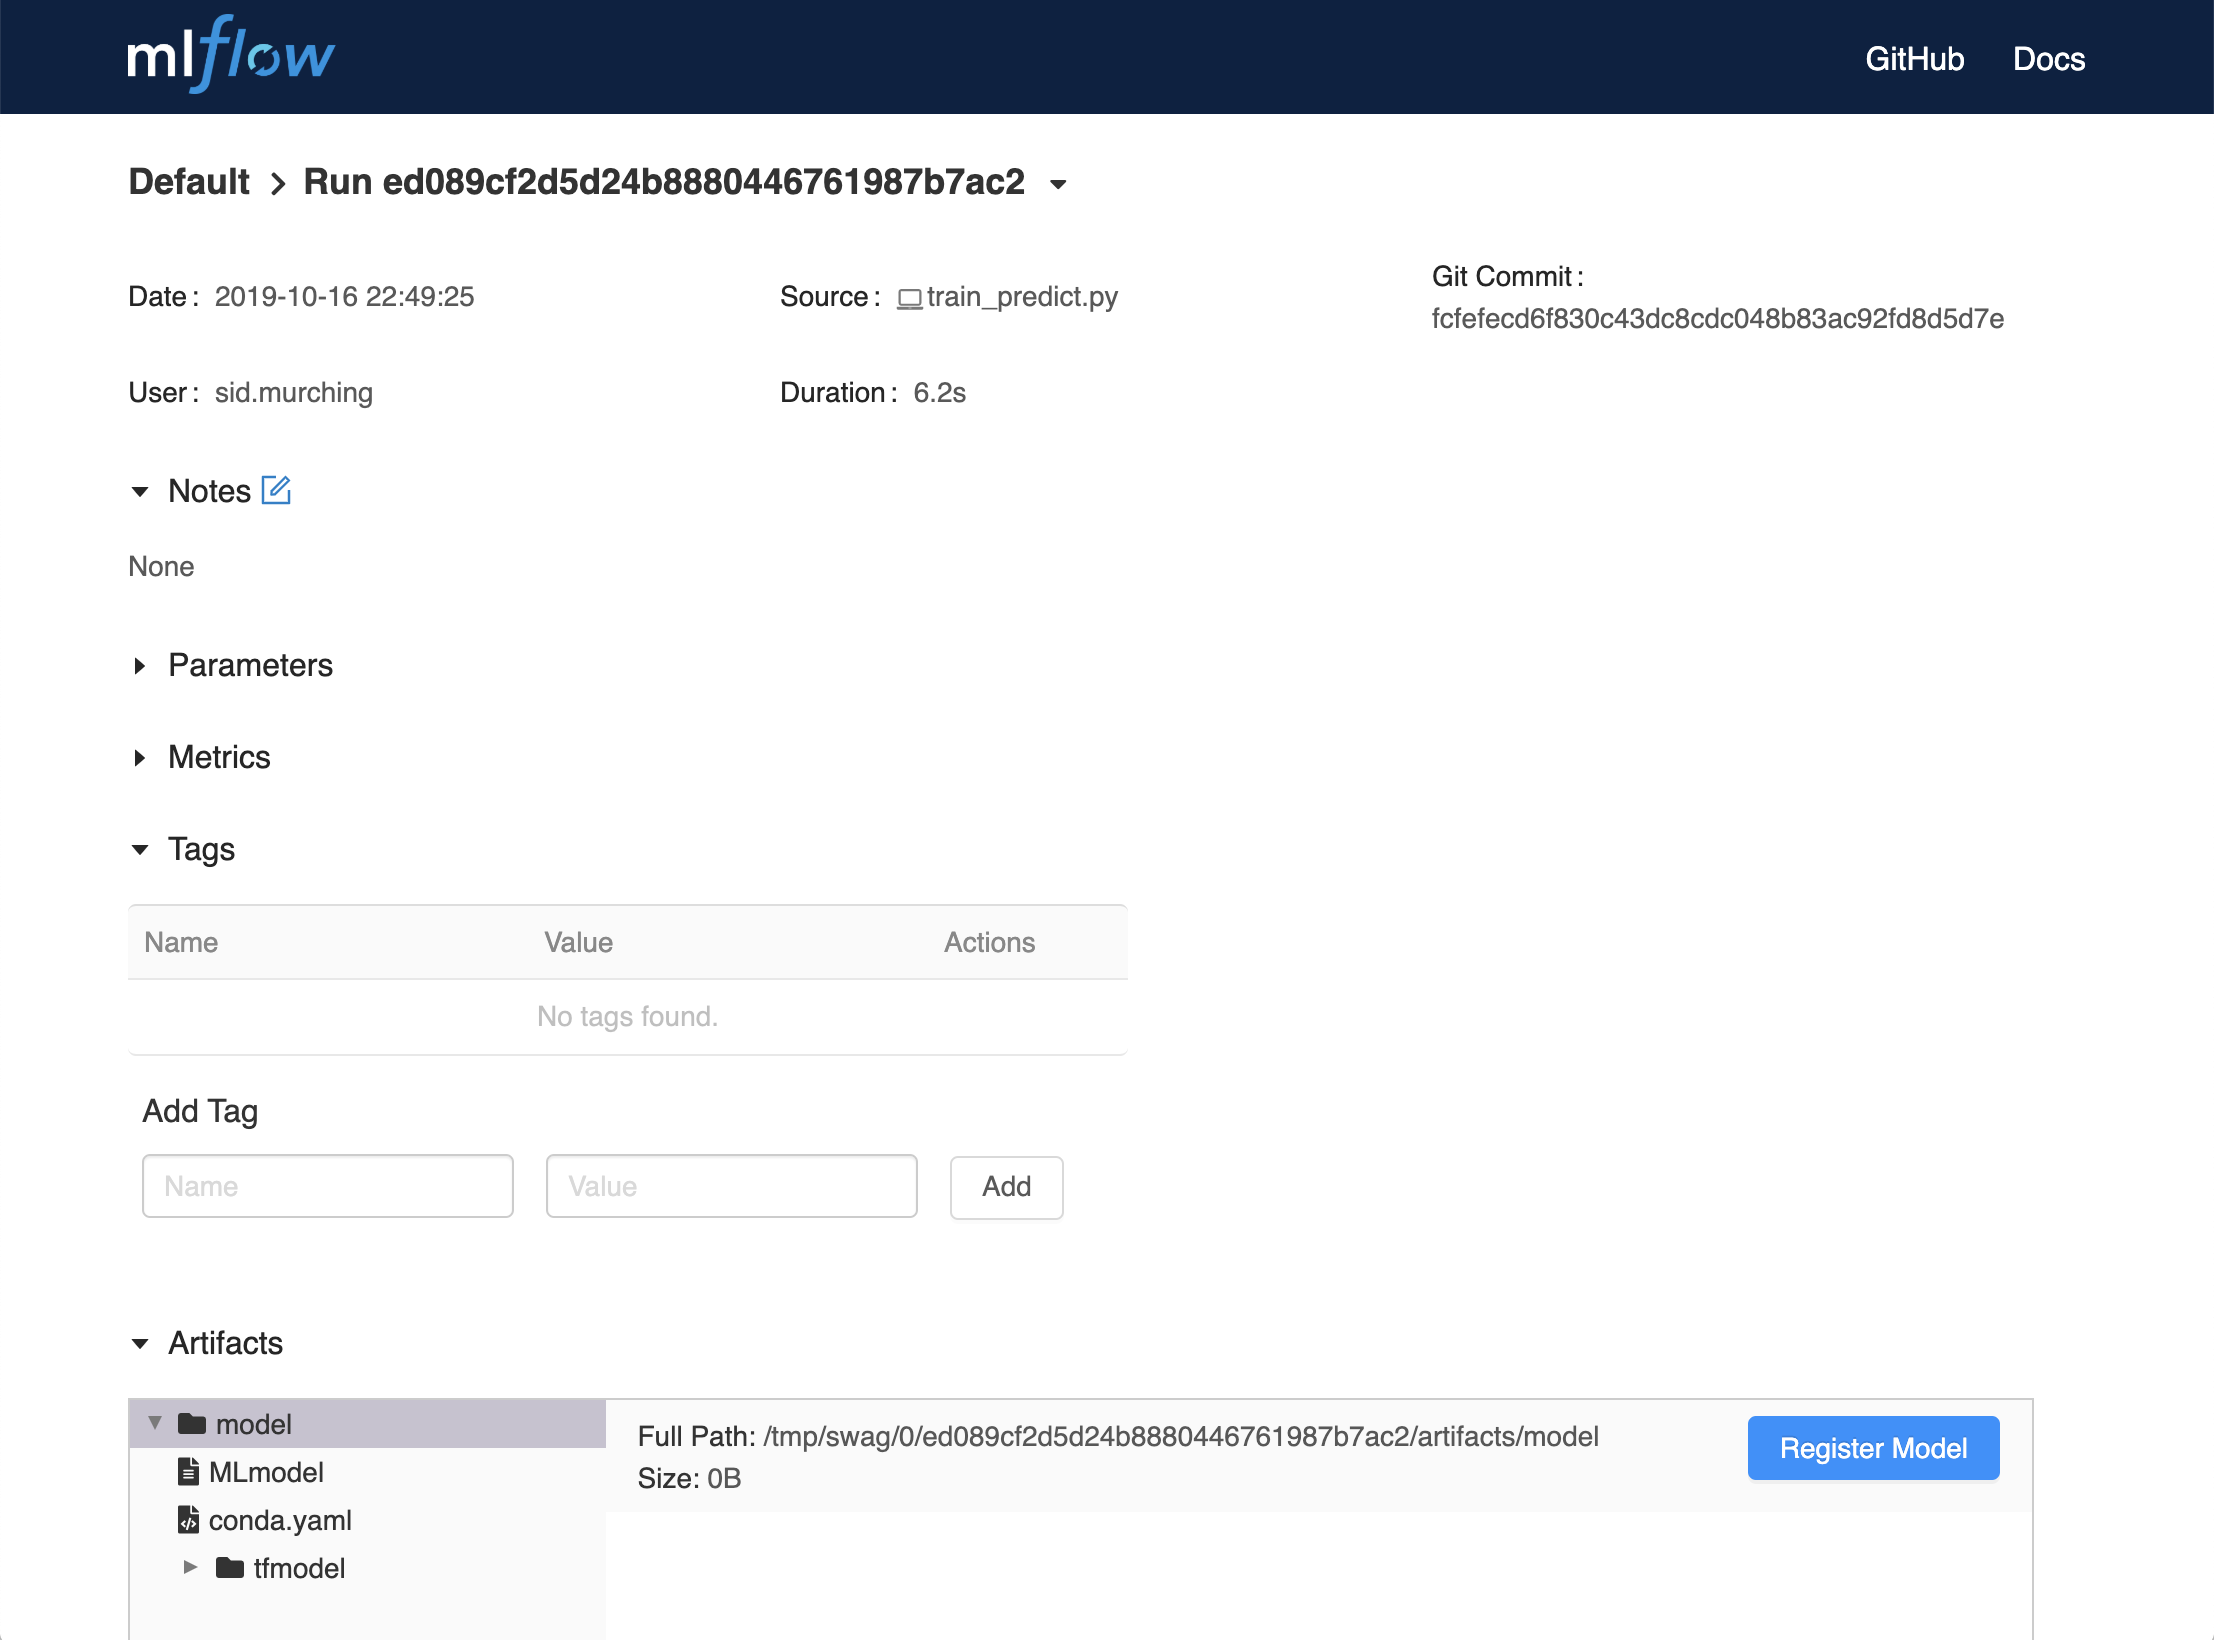

 3. Dans le champ Nom du modèle , si vous ajoutez un nouveau modèle, spécifiez un nom unique pour identifier le modèle. Si vous enregistrez une nouvelle version d'un modèle existant, sélectionnez le nom du modèle existant dans la liste déroulante.
</Br></Br>
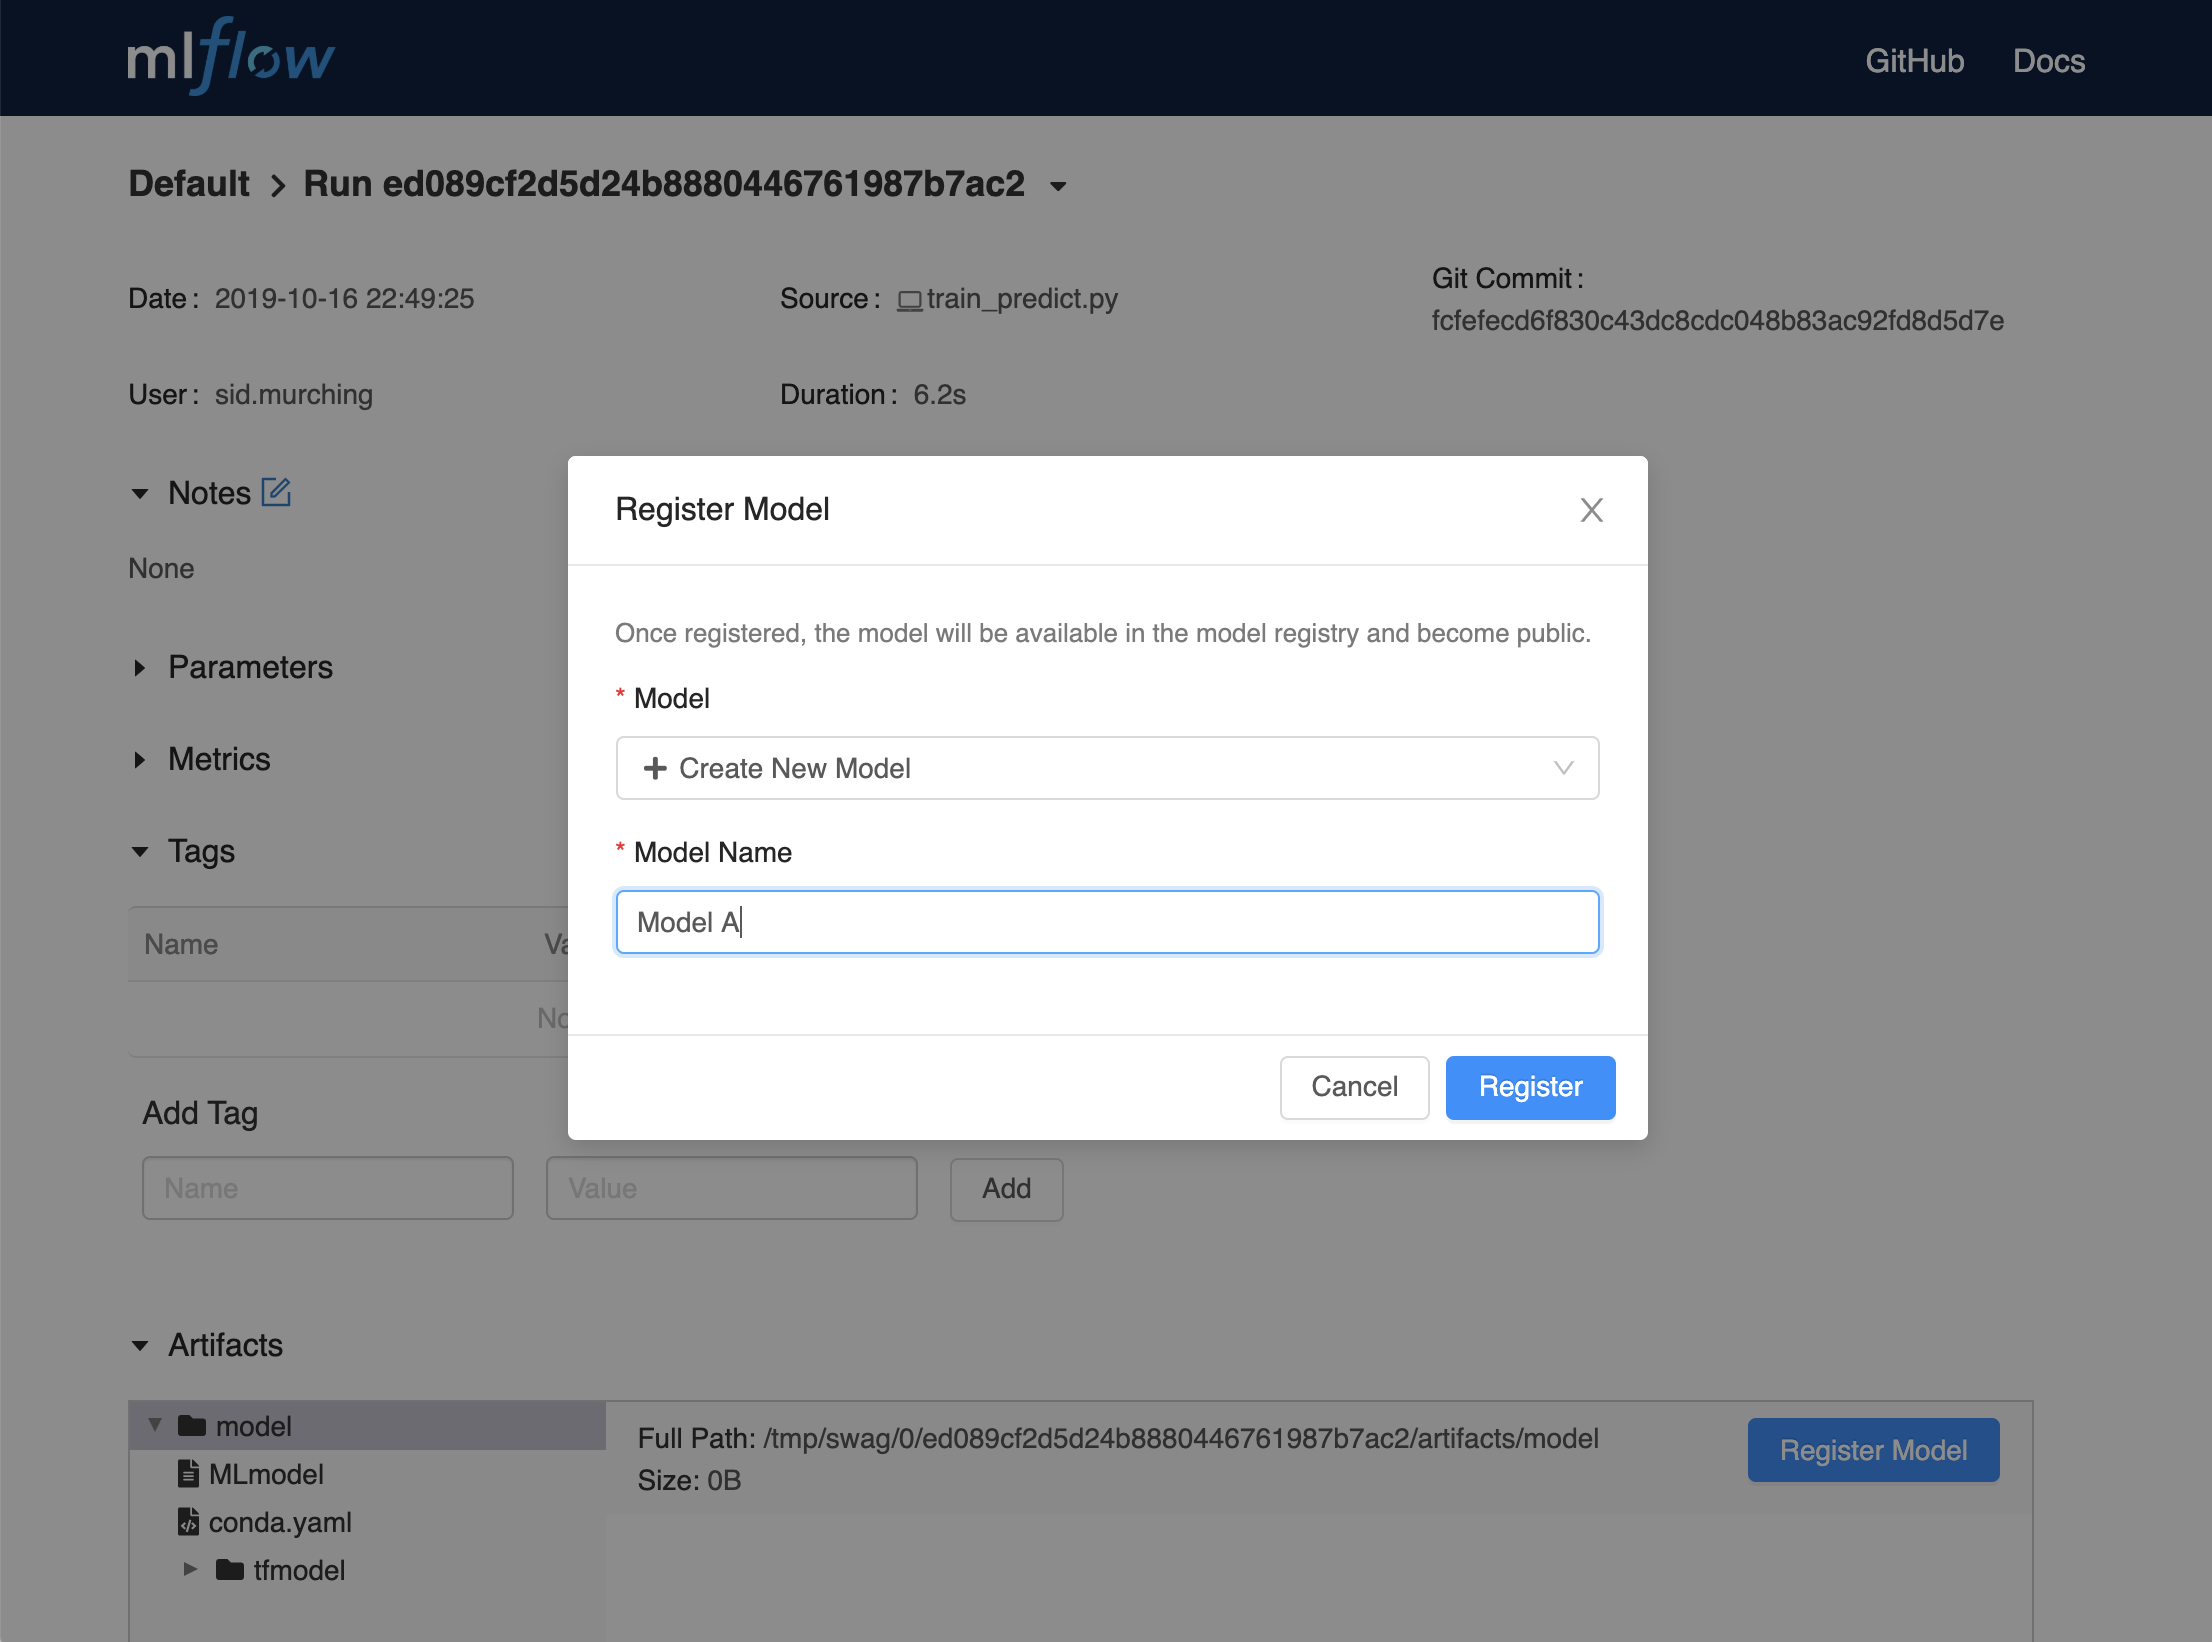

### Utilisation du registre modèle
* Accédez à la page Modèles enregistrés et affichez les propriétés du modèle.
</Br></Br>
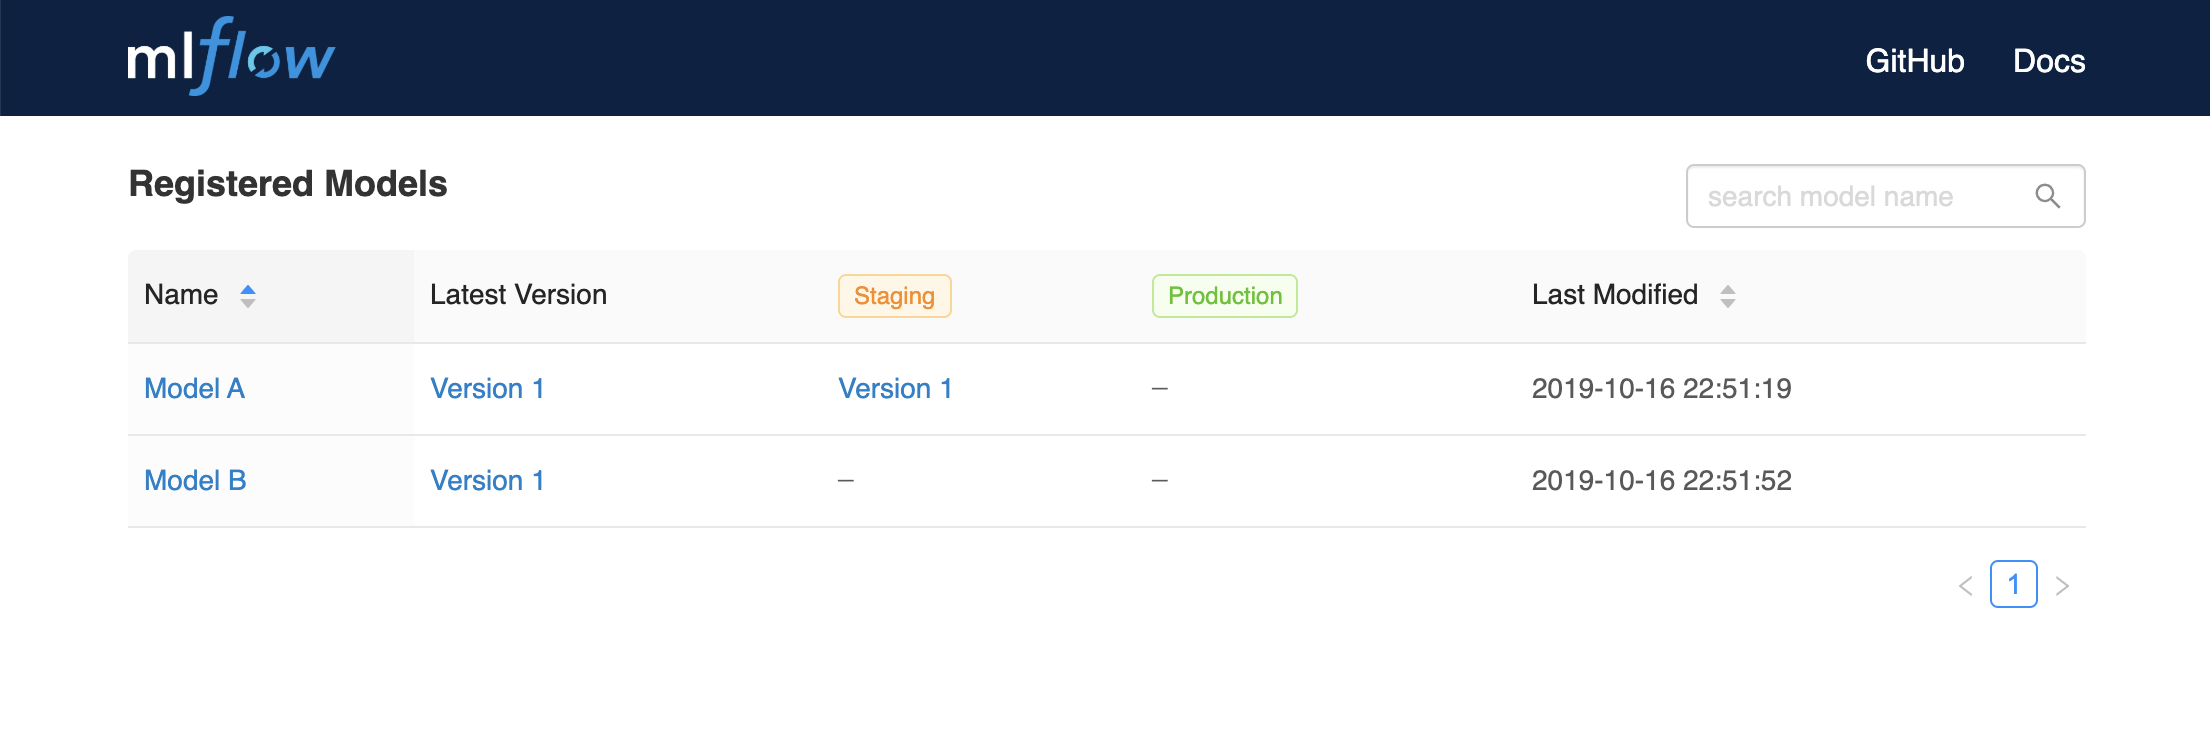

* Accédez à la section Artefacts de la page de détail de l'exécution, cliquez sur le modèle, 
* puis cliquez sur la version du modèle en haut à droite pour afficher la version que vous venez de créer.
</Br></Br>
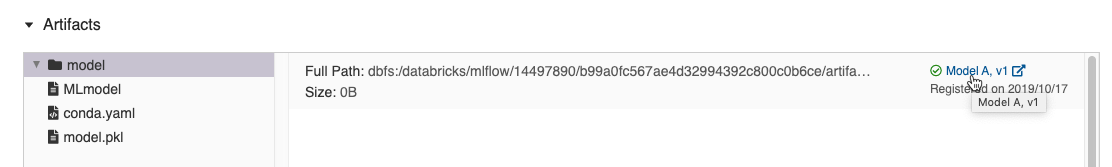

### <a name="C53"><font color='blue'>V.3 Déploiement d'une API REST </font></a>

Les commandes suivantes sont à lancer **depuis le terminal** associé à votre environnement Python.

<img src='../Cours et ressources/logo_oc.png' width=15px /> À partir du modèle MLflow, vous n'êtes plus qu'à une commande de lancer un serveur pour votre API REST ([documentation](https://mlflow.org/docs/latest/models.html#deploy-mlflow-models)).</Br> 
À vous de jouer ! [(en cas de blocage)](https://mlflow.org/docs/latest/cli.html#mlflow-models-serve)

<img src='../Cours et ressources/logo_oc.png' width=15px />  Écrivez la requête curl pour envoyer une requête. Faites attention aux guillemets :)

In [90]:
import streamlit
streamlit

<module 'streamlit' from 'C:\\Users\\eleor\\anaconda3\\envs\\py3_9_projet7_OC_DS\\lib\\site-packages\\streamlit\\__init__.py'>